# STEP 1: FIND NEAR-OPTIMAL PATHS (Nearest Shortest Paths)

In [36]:
import heapq
import time
import copy
from collections import defaultdict
import pulp
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# ======== STEP 1: FIND PATHS FOR OD PAIRS USING NEAR-OPTIMAL PATHS ========

def build_expanded_graph(n_physical, edges):
    """Build the expanded graph with virtual nodes"""
    G_exp = defaultdict(list)
    for u, v, mode, length in edges:
        if mode == 1:  # Road
            G_exp[(u, 1)].append(((v, 1), length))  # Road to Road
            G_exp[(u, 1)].append(((v, 2), length))  # Road to Water
        elif mode == 2:  # Water
            G_exp[(u, 2)].append(((v, 2), length))  # Water to Water
            G_exp[(u, 2)].append(((v, 1), length))  # Water to Road
    return G_exp, n_physical

def dijkstra_multi_target(G_exp, targets):
    """Run Dijkstra's algorithm with multiple targets"""
    dist = defaultdict(lambda: float('inf'))
    heap = []
    for target in targets:
        dist[target] = 0
        heapq.heappush(heap, (0, target))
    while heap:
        d, node = heapq.heappop(heap)
        if d != dist[node]:
            continue
        for neighbor, length in G_exp.get(node, []):
            new_dist = d + length
            if new_dist < dist[neighbor]:
                dist[neighbor] = new_dist
                heapq.heappush(heap, (new_dist, neighbor))
    return dist

def find_shortest_paths(G_exp, n_physical, OD_pairs_physical):
    """Find the shortest paths for OD pairs"""
    shortest_paths = {}
    
    print("FIND SHORTEST PATHS FOR OD PAIRS:")
    print("=" * 50)
    
    for commodity, od_list in OD_pairs_physical.items():
        for od_pair in od_list:
            s, t = od_pair
            print(f"Finding the shortest path from {s} to {t} for commodity {commodity}")
            
            # Find the shortest path using Dijkstra
            min_length = float('inf')
            best_path = None
            
            for start_type in [1, 2]:
                dist = defaultdict(lambda: float('inf'))
                prev = {}
                heap = []
                
                start_node = (s, start_type)
                dist[start_node] = 0
                heapq.heappush(heap, (0, start_node))
                prev[start_node] = None
                
                while heap:
                    d, node = heapq.heappop(heap)
                    u, u_mode = node
                    
                    if u == t:
                        if d < min_length:
                            min_length = d
                            # Reconstruct path
                            path = []
                            current = node
                            while current is not None:
                                path.append(current)
                                current = prev.get(current)
                            path.reverse()
                            best_path = path
                        continue
                    
                    if d != dist[node]:
                        continue
                        
                    for neighbor, length in G_exp.get(node, []):
                        new_dist = d + length
                        if new_dist < dist[neighbor]:
                            dist[neighbor] = new_dist
                            prev[neighbor] = node
                            heapq.heappush(heap, (new_dist, neighbor))
            
            if best_path:
                shortest_paths[(commodity, (s, t))] = (best_path, min_length)
                print(f"  Shortest path: {best_path}")
                print(f"  Length: {min_length}")
            else:
                print(f"  No path found from {s} to {t}")
    
    return shortest_paths

def find_near_optimal_paths(G_exp, n_physical, OD_pairs_physical, epsilon=0.5, max_paths=1000, max_time=30):
    """Find all near-optimal paths for OD pairs"""
    all_paths_for_model = {}
    
    print(f" FIND NEAR-SHORTEST PATHS (epsilon={epsilon}):")
    print("=" * 50)
    
    # First find shortest paths to establish baseline
    shortest_paths = find_shortest_paths(G_exp, n_physical, OD_pairs_physical)
    
    for commodity, od_list in OD_pairs_physical.items():
        for od_pair in od_list:
            s, t = od_pair
            print(f" Finding near-shortest paths from {s} to {t} for commodity {commodity}")
            
            # Get shortest path length for this OD pair
            shortest_key = (commodity, (s, t))
            if shortest_key not in shortest_paths:
                print("  No shortest path, skipping")
                continue
                
            shortest_path, shortest_length = shortest_paths[shortest_key]
            threshold = shortest_length * (1 + epsilon)
            
            print(f"  Shortest path length: {shortest_length}")
            print(f"  Near-optimal threshold: {threshold:.2f}")
            
            # Enumerate all paths using DFS
            start_time = time.time()
            results = []
            for start_type in [1, 2]:
                visited_physical = [False] * n_physical
                visited_physical[s] = True
                stack = [((s, start_type), 0, [], visited_physical)]
                while stack:
                    if time.time() - start_time > max_time or len(results) >= max_paths:
                        break
                    node, total_length, path, visited = stack.pop()
                    u, _ = node
                    if u == t:
                        if total_length <= threshold:
                            results.append((path + [node], total_length))
                        continue
                    for next_node, length in G_exp.get(node, []):
                        v, _ = next_node
                        if not visited[v]:
                            new_path = path + [node]
                            new_length = total_length + length
                            if new_length <= threshold:  # Pruning
                                new_visited = visited.copy()
                                new_visited[v] = True
                                stack.append((next_node, new_length, new_path, new_visited))
            
            # Sort by length
            results.sort(key=lambda x: x[1])
            
            print(f"  Found {len(results)} near-shortest paths")
            for i, (path, length) in enumerate(results):
                print(f"  Path {i+1}: Length {length}, Ratio compared to shortest: {length/shortest_length:.3f}")
            
            all_paths_for_model[(commodity, (s, t))] = results
    
    return all_paths_for_model, shortest_paths


# STEP 2: INPUT DATA FROM TOY EXAMPLE

In [37]:
# ======== STEP 2: PROCESS INPUT DATA ========

def process_input_data():
    """Process and prepare the input data"""
    # Physical graph data
    n_physical = 5
    edges = [
        (0, 2, 1, 45), (0, 2, 2, 41),
        (0, 3, 1, 23), (0, 3, 2, 96),
        (1, 2, 1, 85),
        (1, 3, 1, 13), (1, 3, 2, 21),
        (1, 4, 1, 74), (1, 4, 2, 87),
        (2, 3, 1, 35), (2, 3, 2, 93),
        (3, 4, 1, 67), (3, 4, 2, 85)
    ]
    
    # OD pairs by commodity
    OD_pairs_physical = {
        'g1': [(0, 3), (1, 4)],  # Passenger
        'g2': [(1, 3)]           # Rice
    }
    
    return n_physical, edges, OD_pairs_physical


# STEP 3: FIND ALL NEAR-OPTIMAL PATHS (epsilon = 0.5)


In [38]:
# ======== STEP 3: FIND ALL NEAR-OPTIMAL PATHS ========

def convert_path_to_model_format(path, length):
    """Convert a path from the expanded format to the model format"""
    arcs = []
    for i in range(len(path) - 1):
        u, u_mode = path[i]
        v, v_mode = path[i + 1]
        
        # Create a real arc from u to v's virtual node
        real_arc = (u, f"{v}^{v_mode}")
        arcs.append(real_arc)
        
        # If not the final step, add the virtual arc
        if i < len(path) - 2:
            virtual_arc = (f"{v}^{v_mode}", v)
            arcs.append(virtual_arc)
    
    # Add the virtual arc for the destination
    last_node, last_mode = path[-1]
    virtual_arc_dest = (f"{last_node}^{last_mode}", last_node)
    arcs.append(virtual_arc_dest)
    
    return arcs, length

def prepare_optimization_data(all_paths_for_model):
    """Prepare data for the optimization model"""
    # Convert every path into the model format
    paths_converted = {}
    for key, path_list in all_paths_for_model.items():
        converted_paths = []
        for path, length in path_list:
            model_path, path_length = convert_path_to_model_format(path, length)
            converted_paths.append((model_path, path_length))
        paths_converted[key] = converted_paths
    
    # Shift node indices from 0-based to 1-based
    paths_adjusted = {}
    for (commodity, orig_od), path_list in paths_converted.items():
        orig_s, orig_t = orig_od
        new_od = (orig_s + 1, orig_t + 1)
        paths_adjusted[(commodity, new_od)] = path_list
    
    return paths_adjusted


# STEP 4: CONVERT PATHS -> VIRTUAL ARCS (used in PuLP) and solve the optimization model 


In [42]:
# ======== STEP 4: CONVERT PATHS TO VIRTUAL ARCS AND SOLVE THE OPTIMIZATION MODEL ========

def create_optimization_model(paths_adjusted):
    """Build and solve the optimization model"""
    # 1. SET UP INPUT DATA
    T = [1, 2]  # Time periods
    
    # Node definitions
    real_nodes = [1, 2, 3, 4, 5]  # 1-based nodes
    virtual_nodes = ['3^1', '3^2', '4^1', '4^2', '5^1', '5^2']
    all_nodes = real_nodes + virtual_nodes
    
    # Hubs
    H = [3]  # Can Tho
    potential_hubs = [3]
    existing_hubs = []
    
    # Collect all arcs from the discovered paths
    real_arcs = []
    virtual_arcs = []
    for path_list in paths_adjusted.values():
        for path, _ in path_list:
            for arc in path:
                if '^' in str(arc[1]):  # Real arc
                    if arc not in real_arcs:
                        real_arcs.append(arc)
                else:  # Virtual arc
                    if arc not in virtual_arcs:
                        virtual_arcs.append(arc)
    
    print(f"Real arcs: {real_arcs}")
    print(f"Virtual arcs: {virtual_arcs}")
    
    # All arcs
    A = real_arcs + virtual_arcs
    potential_arcs = [(3, '4^1'), (3, '4^2')]  # Arcs that can be upgraded
    existing_arcs = [arc for arc in A if arc not in potential_arcs]
    
    # Commodities
    commodities = {'passenger': 'g1', 'rice': 'g2'}
    
    # Origin-destination pairs (1-based)
    OD_pairs = {
        'g1': [(1, 4), (2, 5)],  # Passenger
        'g2': [(2, 4)]           # Rice
    }
    
    # Transportation costs on arcs
    arc_costs = {}
    for arc in real_arcs:
        arc_costs[arc] = 1  # Default cost
    for arc in virtual_arcs:
        arc_costs[arc] = 0  # Virtual arcs have zero cost
    
    # Additional parameters
    switch_cost = 2
    hub_service_cost = {3: 1}
    hub_upgrade_cost = 1000
    hub_capacity = {0: 2000, 1: 7000}
    
    arc_upgrade_costs = {
        (3, '4^1'): 800,
        (3, '4^2'): 500
    }
    
    arc_capacities = {
        (3, '4^1'): {0: 0, 1: 3000},
        (3, '4^2'): {0: 0, 1: 4000}
    }
    
    existing_hub_capacity = 2000
    existing_arc_capacity = 2000
    
    # Transportation demand
    demands = {
        ('g1', (1, 4)): 3000,  # Passenger from An Giang -> Ho Chi Minh City
        ('g1', (2, 5)): 2800,  # Passenger from Dong Thap -> Vinh Long
        ('g2', (2, 4)): 4000   # Rice from Dong Thap -> Ho Chi Minh City
    }
    
    # 2. INITIALIZE MODEL AND DECISION VARIABLES
    model = pulp.LpProblem("Multimodal_Transport_Network_Optimization", pulp.LpMinimize)
    
    # Decision variables
    y_hub = pulp.LpVariable.dicts(
        "y_hub", 
        [(h, l, t) for h in potential_hubs for l in [0, 1] for t in T],
        cat='Binary'
    )
    
    y_arc = pulp.LpVariable.dicts(
        "y_arc", 
        [(a[0], a[1], l, t) for a in potential_arcs for l in [0, 1] for t in T],
        cat='Binary'
    )
    
    v_path = {}
    for g, od_pairs in OD_pairs.items():
        for od in od_pairs:
            for idx, _ in enumerate(paths_adjusted[(g, od)]):
                for t in T:
                    v_name = f"v_{g}_{od[0]}_{od[1]}_p{idx+1}_t{t}"
                    v_path[(g, od, idx, t)] = pulp.LpVariable(v_name, lowBound=0, upBound=1)
    
    u_hub = pulp.LpVariable.dicts(
        "u_hub", 
        [(h, t) for h in H for t in T],
        lowBound=0
    )
    
    x_arc = pulp.LpVariable.dicts(
        "x_arc", 
        [(a[0], a[1], t) for a in A for t in T],
        lowBound=0
    )
    
    # 3. BUILD OBJECTIVE FUNCTION
    investment_cost = pulp.lpSum(
        [hub_upgrade_cost * hub_capacity[l] * y_hub[(h, l, t)] 
            for h in potential_hubs for l in [0, 1] for t in T] 
        + 
        [arc_upgrade_costs[a] * arc_capacities[a][l] * y_arc[(a[0], a[1], l, t)] 
            for a in potential_arcs for l in [0, 1] for t in T]
    )
    
    service_cost = pulp.lpSum(
        hub_service_cost[h] * u_hub[(h, t)] 
        for h in H for t in T
    )
    
    transport_cost = pulp.lpSum(0)
    for g, od_pairs in OD_pairs.items():
        for od in od_pairs:
            demand = demands[(g, od)]
            for idx, (path, _) in enumerate(paths_adjusted[(g, od)]):
                # Compute the transport cost for the path
                path_cost = 0
                mode_switches = 0
                prev_mode = None
                
                for arc in path:
                    path_cost += arc_costs[arc]
                    current_mode = 'road' if str(arc[1]).endswith('^1') else 'water'
                    if prev_mode and prev_mode != current_mode:
                        mode_switches += 1
                    prev_mode = current_mode
                
                path_cost += mode_switches * switch_cost
                
                for t in T:
                    transport_cost += path_cost * demand * v_path[(g, od, idx, t)]
    
    model += investment_cost + service_cost + transport_cost
    
    # 4. CONSTRAINTS
    # Flow allocation constraint
    for g, od_pairs in OD_pairs.items():
        for od in od_pairs:
            for t in T:
                model += pulp.lpSum(v_path[(g, od, idx, t)] for idx in range(len(paths_adjusted[(g, od)]))) == 1
    
    # Calculate flow through hubs
    for h in H:
        for t in T:
            total_flow = 0
            for g, od_pairs in OD_pairs.items():
                for od in od_pairs:
                    demand = demands[(g, od)]
                    for idx, (path, _) in enumerate(paths_adjusted[(g, od)]):
                        if any(arc[1] == str(h) or arc[1] == h for arc in path):
                            total_flow += demand * v_path[(g, od, idx, t)]
            model += u_hub[(h, t)] == total_flow
    
    # Calculate flow through arcs
    for arc in A:
        for t in T:
            total_flow = 0
            for g, od_pairs in OD_pairs.items():
                for od in od_pairs:
                    demand = demands[(g, od)]
                    for idx, (path, _) in enumerate(paths_adjusted[(g, od)]):
                        if arc in path:
                            total_flow += demand * v_path[(g, od, idx, t)]
            model += x_arc[(arc[0], arc[1], t)] == total_flow
    
    # Hub capacity constraints
    for h in potential_hubs:
        for t in T:
            model += u_hub[(h, t)] <= pulp.lpSum(
                hub_capacity[l] * y_hub[(h, l, t)] for l in [0, 1]
            )
    
    # Arc capacity constraints
    for a in potential_arcs:
        for t in T:
            model += x_arc[(a[0], a[1], t)] <= pulp.lpSum(
                arc_capacities[a][l] * y_arc[(a[0], a[1], l, t)] 
                for l in [0, 1]
            )
    
    for a in existing_arcs:
        if a in real_arcs:
            for t in T:
                model += x_arc[(a[0], a[1], t)] <= existing_arc_capacity
    
    # Logic constraints
    for h in potential_hubs:
        for t in T:
            model += pulp.lpSum(y_hub[(h, l, t)] for l in [0, 1]) == 1
    
    for a in potential_arcs:
        for t in T:
            model += pulp.lpSum(y_arc[(a[0], a[1], l, t)] for l in [0, 1]) == 1
    
    # Non-decreasing capacity constraints
    for h in potential_hubs:
        for t_idx, t in enumerate(T[:-1]):
            t_next = T[t_idx + 1]
            model += pulp.lpSum(
                hub_capacity[l] * y_hub[(h, l, t_next)] for l in [0, 1]
            ) >= pulp.lpSum(
                hub_capacity[l] * y_hub[(h, l, t)] for l in [0, 1]
            )
    
    for a in potential_arcs:
        for t_idx, t in enumerate(T[:-1]):
            t_next = T[t_idx + 1]
            model += pulp.lpSum(
                arc_capacities[a][l] * y_arc[(a[0], a[1], l, t_next)] for l in [0, 1]
            ) >= pulp.lpSum(
                arc_capacities[a][l] * y_arc[(a[0], a[1], l, t)] for l in [0, 1]
            )
    
    return model, {
        'y_hub': y_hub, 'y_arc': y_arc, 'v_path': v_path, 
        'u_hub': u_hub, 'x_arc': x_arc,
        'OD_pairs': OD_pairs, 'paths_adjusted': paths_adjusted,
        'demands': demands, 'commodities': commodities,
        'potential_hubs': potential_hubs, 'potential_arcs': potential_arcs,
        'T': T, 'real_nodes': real_nodes, 'virtual_nodes': virtual_nodes,
        'real_arcs': real_arcs, 'virtual_arcs': virtual_arcs}

def solve_and_display_results(model, data):
    """Solve the model and display the results"""
    print("" + "="*50)
    print("START SOLVING THE OPTIMIZATION MODEL")
    print("="*50)
    
    model.solve()
    
    print(f"Solution status: {pulp.LpStatus[model.status]}")
    print(f"Optimal total cost: {pulp.value(model.objective):.2f}")
    
    # Display results
    def get_province_name(node_id):
        names = {
            0: "An Giang",
            1: "Dong Thap", 
            2: "Can Tho",
            3: "Ho Chi Minh City",
            4: "Vinh Long" }
        return names.get(node_id, f"Node {node_id}")
    
    print("OPTIMAL RESULTS:")
    
    # Decision variables
    print("[1] HUB UPGRADE PLAN:")
    hub_investment = {}
    for h in data['potential_hubs']:
        hub_investment[h] = {}
        for t in data['T']:
            for l in [0, 1]:
                if pulp.value(data['y_hub'][(h, l, t)]) > 0.5:
                    capacity = 2000 if l == 0 else 7000
                    action = "UPGRADE" if l == 1 else "UNCHANGED"
                    hub_investment[h][t] = (action, capacity)
                    print(f"  Hub {get_province_name(h-1)} - Period {t}: {action} (capacity: {capacity})")
    
    print("[2] ARC UPGRADE PLAN:")
    arc_investment = {}
    for a in data['potential_arcs']:
        arc_investment[a] = {}
        for t in data['T']:
            for l in [0, 1]:
                if pulp.value(data['y_arc'][(a[0], a[1], l, t)]) > 0.5:
                    capacity = 0 if l == 0 else (3000 if '^1' in a[1] else 4000)
                    mode = "ROAD" if '^1' in a[1] else "WATERWAY"
                    action = "UPGRADE" if l == 1 else "UNCHANGED"
                    arc_investment[a][t] = (action, capacity, mode)
                    print(f"  Arc {get_province_name(a[0]-1)}->{get_province_name(int(a[1].split('^')[0])-1)} ({mode}) - Period {t}: {action} (capacity: {capacity})")
    
    print(" [3] TRANSPORT FLOW ALLOCATION:")
    flow_allocation = {}
    for g_name, g_code in data['commodities'].items():
        flow_allocation[g_code] = {}
        print(f" Commodity: {g_name.upper()}")
        for od in data['OD_pairs'][g_code]:
            origin, dest = od
            flow_allocation[g_code][od] = {}
            print(f"    Route: {get_province_name(origin-1)} -> {get_province_name(dest-1)}")
            for t in data['T']:
                flow_allocation[g_code][od][t] = []
                print(f"      Period {t}:")
                total_flow = 0
                for idx, (path, path_length) in enumerate(data['paths_adjusted'][(g_code, od)]):
                    flow_value = pulp.value(data['v_path'][(g_code, od, idx, t)])
                    if flow_value is not None and flow_value > 0.001:
                        flow_amount = data['demands'][(g_code, od)] * flow_value
                        total_flow += flow_amount
                        flow_allocation[g_code][od][t].append((idx, flow_amount, path))
                        path_desc = " -> ".join([f"{get_province_name(arc[0]-1) if isinstance(arc[0], int) else arc[0]}->{get_province_name(arc[1]-1) if isinstance(arc[1], int) else arc[1]}" for arc in path])
                        print(f"        Path {idx+1}: {flow_amount:.2f} units")
                        print(f"          Route: {path_desc}")
                print(f"        Total flow: {total_flow:.2f}")
    
    print("[4] COST SUMMARY:")
    investment_cost = pulp.lpSum(
        [1000 * (2000 if l == 0 else 7000) * data['y_hub'][(h, l, t)] 
            for h in data['potential_hubs'] for l in [0, 1] for t in data['T']] 
        + 
        [({(3, '4^1'): 800, (3, '4^2'): 500}[a] * ({0: 0, 1: 3000} if '^1' in a[1] else {0: 0, 1: 4000})[l] * data['y_arc'][(a[0], a[1], l, t)]) 
            for a in data['potential_arcs'] for l in [0, 1] for t in data['T']])
    
    service_cost = pulp.lpSum(
        1 * data['u_hub'][(h, t)] 
        for h in [3] for t in data['T'] )
    
    transport_cost = pulp.lpSum(0)
    for g, od_pairs in data['OD_pairs'].items():
        for od in od_pairs:
            demand = data['demands'][(g, od)]
            for idx, (path, _) in enumerate(data['paths_adjusted'][(g, od)]):
                path_cost = 0
                mode_switches = 0
                prev_mode = None
                
                for arc in path:
                    path_cost += (1 if '^' in str(arc[1]) else 0)
                    current_mode = 'road' if str(arc[1]).endswith('^1') else 'water'
                    if prev_mode and prev_mode != current_mode:
                        mode_switches += 1
                    prev_mode = current_mode
                
                path_cost += mode_switches * 2
                
                for t in data['T']:
                    transport_cost += path_cost * demand * data['v_path'][(g, od, idx, t)]
    
    print(f"  Investment cost: {pulp.value(investment_cost):.2f}")
    print(f"  Hub service cost: {pulp.value(service_cost):.2f}") 
    print(f"  Transport cost: {pulp.value(transport_cost):.2f}")
    print(f"  TOTAL: {pulp.value(model.objective):.2f}")
    
    return model, hub_investment, arc_investment, flow_allocation


# STEP 5: Visualization


In [45]:
# ======== VISUALIZATION ========

def draw_original_network(n_physical, edges):
    """Draw the baseline network with transport modes separated"""
    plt.figure(figsize=(14, 10))

    # Build the graph
    G = nx.MultiDiGraph()
    for i in range(n_physical):
        G.add_node(i)
    for u, v, mode, length in edges:
        G.add_edge(u, v, mode=mode, length=length)

    # Layout
    pos = {
        0: (0, 2),   # An Giang
        1: (2, 3),   # Dong Thap
        2: (4, 2),   # Can Tho
        3: (6, 3),   # Ho Chi Minh City
        4: (2, 1)    # Vinh Long
    }

    # Nodes and labels
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1500, alpha=0.9)
    node_labels = {0: 'An Giang', 1: 'Dong Thap', 2: 'Can Tho', 3: 'Ho Chi Minh City', 4: 'Vinh Long'}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12, font_weight='bold')

    # Separate edges by mode
    road_edges = [(u, v) for u, v, mode, length in edges if mode == 1]
    water_edges = [(u, v) for u, v, mode, length in edges if mode == 2]

    # Road (red)
    nx.draw_networkx_edges(
        G, pos, edgelist=road_edges,
        edge_color='red', width=2,
        arrows=True, arrowsize=20,
        label='Road'
    )

    # Waterway (blue dashed)
    nx.draw_networkx_edges(
        G, pos, edgelist=water_edges,
        edge_color='blue', width=2, style='dashed',
        arrows=True, arrowsize=20,
        label='Waterway'
    )

    # Edge labels
    road_labels = {(u, v): f'{length}' for u, v, mode, length in edges if mode == 1}
    water_labels = {(u, v): f'{length}' for u, v, mode, length in edges if mode == 2}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=road_labels, font_size=8, label_pos=0.3)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=water_labels, font_size=8, label_pos=0.7)

    plt.title( "BASELINE TRANSPORT NETWORK (Road: red, Waterway: blue dashed)", fontsize=16, fontweight='bold', pad=20)
    plt.legend(loc='upper right')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def draw_shortest_paths(shortest_paths):
    """Visualize the shortest paths"""
    plt.figure(figsize=(14, 10))
    G = nx.DiGraph()

    pos = {
        0: (0, 2),   # An Giang
        1: (2, 3),   # Dong Thap
        2: (4, 2),   # Can Tho
        3: (6, 3),   # Ho Chi Minh City
        4: (2, 1)    # Vinh Long
    }

    for i in range(5):
        G.add_node(i)

    colors = {'g1': 'red', 'g2': 'green'}
    labels = {'g1': 'Passenger', 'g2': 'Rice'}

    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1500, alpha=0.9)
    node_labels = {0: 'An Giang', 1: 'Dong Thap', 2: 'Can Tho', 3: 'Ho Chi Minh City', 4: 'Vinh Long'}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12, font_weight='bold')

    legend_handles = []
    for (commodity, od), (path, length) in shortest_paths.items():
        color = colors.get(commodity, 'black')
        label = labels.get(commodity, commodity)
        for i in range(len(path) - 1):
            u, u_mode = path[i]
            v, v_mode = path[i + 1]
            G.add_edge(u, v, commodity=commodity, mode=u_mode)
        edges = [(u, v) for u, v, data in G.edges(data=True) if data.get('commodity') == commodity]
        if edges:
            nx.draw_networkx_edges(
                G, pos, edgelist=edges,
                edge_color=color, width=3,
                arrows=True, arrowsize=25,
                style='dashed' if commodity == 'g2' else 'solid'
            )
            from matplotlib.lines import Line2D
            legend_handles.append(Line2D([0], [0], color=color, lw=3, label=f'{label} (length: {length})'))

    plt.title("SHORTEST PATHS FOR OD PAIRS", fontsize=16, fontweight='bold', pad=20)
    if legend_handles:
        plt.legend(handles=legend_handles, loc='upper right')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def draw_upgrade_plan(hub_investment, arc_investment):
    """Draw the upgrade plan for each period"""
    def get_province_name(node_id):
        names = {
            0: "An Giang",
            1: "Dong Thap", 
            2: "Can Tho",
            3: "Ho Chi Minh City",
            4: "Vinh Long"
        }
        return names.get(node_id, f"Node {node_id}")

    for t in [1, 2]:
        plt.figure(figsize=(14, 10))
        G = nx.DiGraph()
        pos = {
            0: (0, 2),   # An Giang
            1: (2, 3),   # Dong Thap
            2: (4, 2),   # Can Tho
            3: (6, 3),   # Ho Chi Minh City
            4: (2, 1)    # Vinh Long
        }
        for i in range(5):
            G.add_node(i)

        node_colors = []
        for i in range(5):
            if i == 2:  # Can Tho hub
                if 3 in hub_investment and t in hub_investment[3]:
                    action, capacity = hub_investment[3][t]
                    node_colors.append('orange' if action == "UPGRADE" else 'lightblue')
                else:
                    node_colors.append('lightblue')
            else:
                node_colors.append('lightblue')

        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1500, alpha=0.9)
        node_labels = {0: 'An Giang', 1: 'Dong Thap', 2: 'Can Tho', 3: 'Ho Chi Minh City', 4: 'Vinh Long'}
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12, font_weight='bold')

        legend_handles = []
        from matplotlib.lines import Line2D
        for arc, investment_info in arc_investment.items():
            if t in investment_info:
                action, capacity, mode = investment_info[t]
                u, v_str = arc
                v = int(v_str.split('^')[0]) - 1
                color = 'red' if 'ROAD' in mode else 'blue'
                style = 'solid' if action == "UPGRADE" else 'dashed'
                width = 4 if action == "UPGRADE" else 2
                G.add_edge(u - 1, v, action=action, mode=mode)
                nx.draw_networkx_edges(
                    G, pos, edgelist=[(u - 1, v)],
                    edge_color=color, width=width,
                    style=style, arrows=True, arrowsize=25
                )
                status = "UPGRADED" if action == "UPGRADE" else "UNCHANGED"
                legend_handles.append(Line2D([0], [0], color=color, lw=width, linestyle=style,
                                             label=f'{mode} - {status} (capacity: {capacity})'))

        plt.title(f"UPGRADE PLAN - PERIOD {t}", fontsize=16, fontweight='bold', pad=20)
        if legend_handles:
            plt.legend(handles=legend_handles, loc='upper right')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

def draw_flow_distribution(flow_allocation, commodities, T):
    """Visualize the flow distribution for each commodity over time"""
    def normalize_node(node):
        """Normalize node IDs to 0-based indexing"""
        if isinstance(node, int):
            if 1 <= node <= 5:
                return node - 1
            return node
        if isinstance(node, str) and '^' in node:
            base_node = int(node.split('^')[0])
            return base_node - 1
        return node

    commodity_styles = {
        'g1': {'color': 'red', 'style': 'solid', 'marker': 'o'},
        'g2': {'color': 'green', 'style': 'dashed', 'marker': 's'}
    }
    commodity_names = {'g1': 'Passenger', 'g2': 'Rice'}

    pos = {
        0: (0, 2),   # An Giang
        1: (2, 3),   # Dong Thap
        2: (4, 2),   # Can Tho
        3: (6, 3),   # Ho Chi Minh City
        4: (2, 1)    # Vinh Long
    }

    for g_code, od_flows in flow_allocation.items():
        for t in T:
            plt.figure(figsize=(14, 10))
            G = nx.DiGraph()
            for i in range(5):
                G.add_node(i)
            nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1500, alpha=0.9)
            node_labels = {0: 'An Giang', 1: 'Dong Thap', 2: 'Can Tho', 3: 'Ho Chi Minh City', 4: 'Vinh Long'}
            nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12, font_weight='bold')

            edge_flows = {}
            for od, time_flows in od_flows.items():
                if t in time_flows:
                    for idx, flow_amount, path in time_flows[t]:
                        for step in path:
                            u, v = step
                            u_norm = normalize_node(u)
                            v_norm = normalize_node(v)
                            if None not in (u_norm, v_norm) and 0 <= u_norm <= 4 and 0 <= v_norm <= 4:
                                edge = (u_norm, v_norm)
                                edge_flows[edge] = edge_flows.get(edge, 0) + flow_amount

            if not edge_flows:
                print(f"No flow for {commodity_names[g_code]} in period {t}")
                plt.close()
                continue

            max_flow = max(edge_flows.values()) if edge_flows else 1
            for edge, flow in edge_flows.items():
                u, v = edge
                if u in pos and v in pos:
                    G.add_edge(u, v, flow=flow)
                    width = max(1, flow / max_flow * 10)
                    style = commodity_styles[g_code]['style']
                    color = commodity_styles[g_code]['color']
                    nx.draw_networkx_edges(
                        G, pos, edgelist=[(u, v)],
                        edge_color=color, width=width,
                        style=style, arrows=True, arrowsize=25
                    )

            from matplotlib.lines import Line2D
            legend_handle = Line2D([0], [0], color=commodity_styles[g_code]['color'], lw=3,
                                   label=commodity_names[g_code])

            edge_labels = {(u, v): f"{data['flow']:.0f}" for u, v, data in G.edges(data=True) if 'flow' in data}
            nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)

            plt.title( f"TRANSPORT FLOW ALLOCATION - {commodity_names[g_code].upper()} - PERIOD {t} (Thickness represents flow amount)", fontsize=16, fontweight='bold', pad=20)
            plt.legend(handles=[legend_handle], loc='upper right')
            plt.axis('off')
            plt.tight_layout()
            plt.show()


# MAIN FUNCTION AND OUTPUT


START MULTIMODAL TRANSPORT NETWORK OPTIMIZATION PROGRAM
 STEP 1 & 2: PROCESS INPUT DATA
----------------------------------------
Number of physical nodes: 5
Number of arcs: 13
Number of OD pairs: 3
 Drawing the baseline network...


/var/folders/h2/d9kh_4lx0xqb4w42jm_jrvbw0000gn/T/ipykernel_5392/1086561112.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


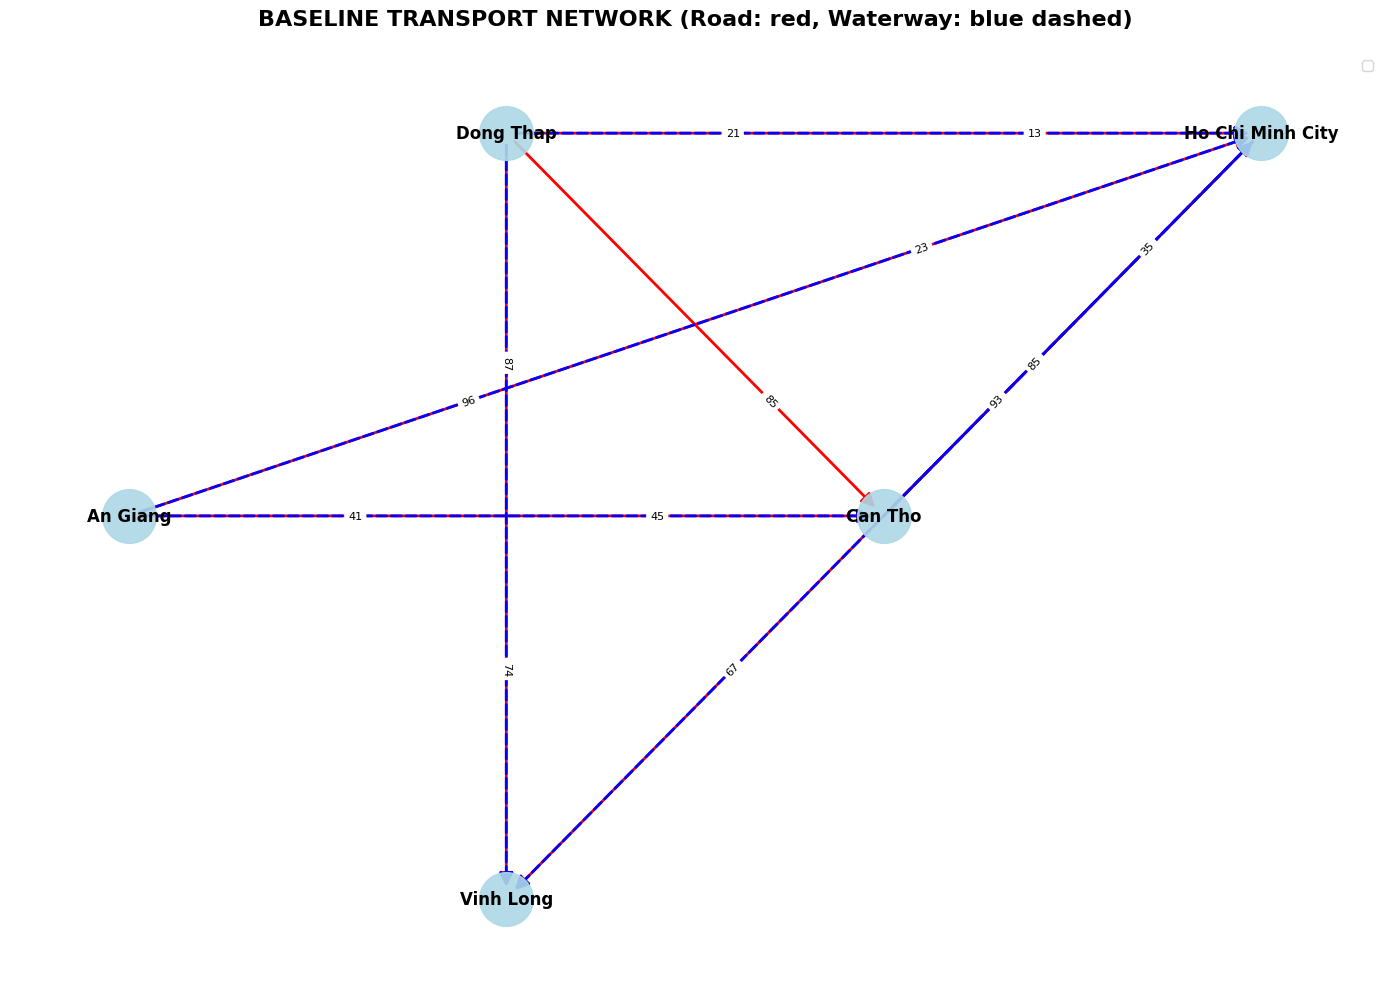

STEP 3: FIND SHORTEST AND NEAR-OPTIMAL PATHS
----------------------------------------
FIND SHORTEST PATHS FOR OD PAIRS:
Finding the shortest path from 0 to 3 for commodity g1
  Shortest path: [(0, 1), (3, 1)]
  Length: 23
Finding the shortest path from 1 to 4 for commodity g1
  Shortest path: [(1, 1), (4, 1)]
  Length: 74
Finding the shortest path from 1 to 3 for commodity g2
  Shortest path: [(1, 1), (3, 1)]
  Length: 13
Drawing shortest paths...


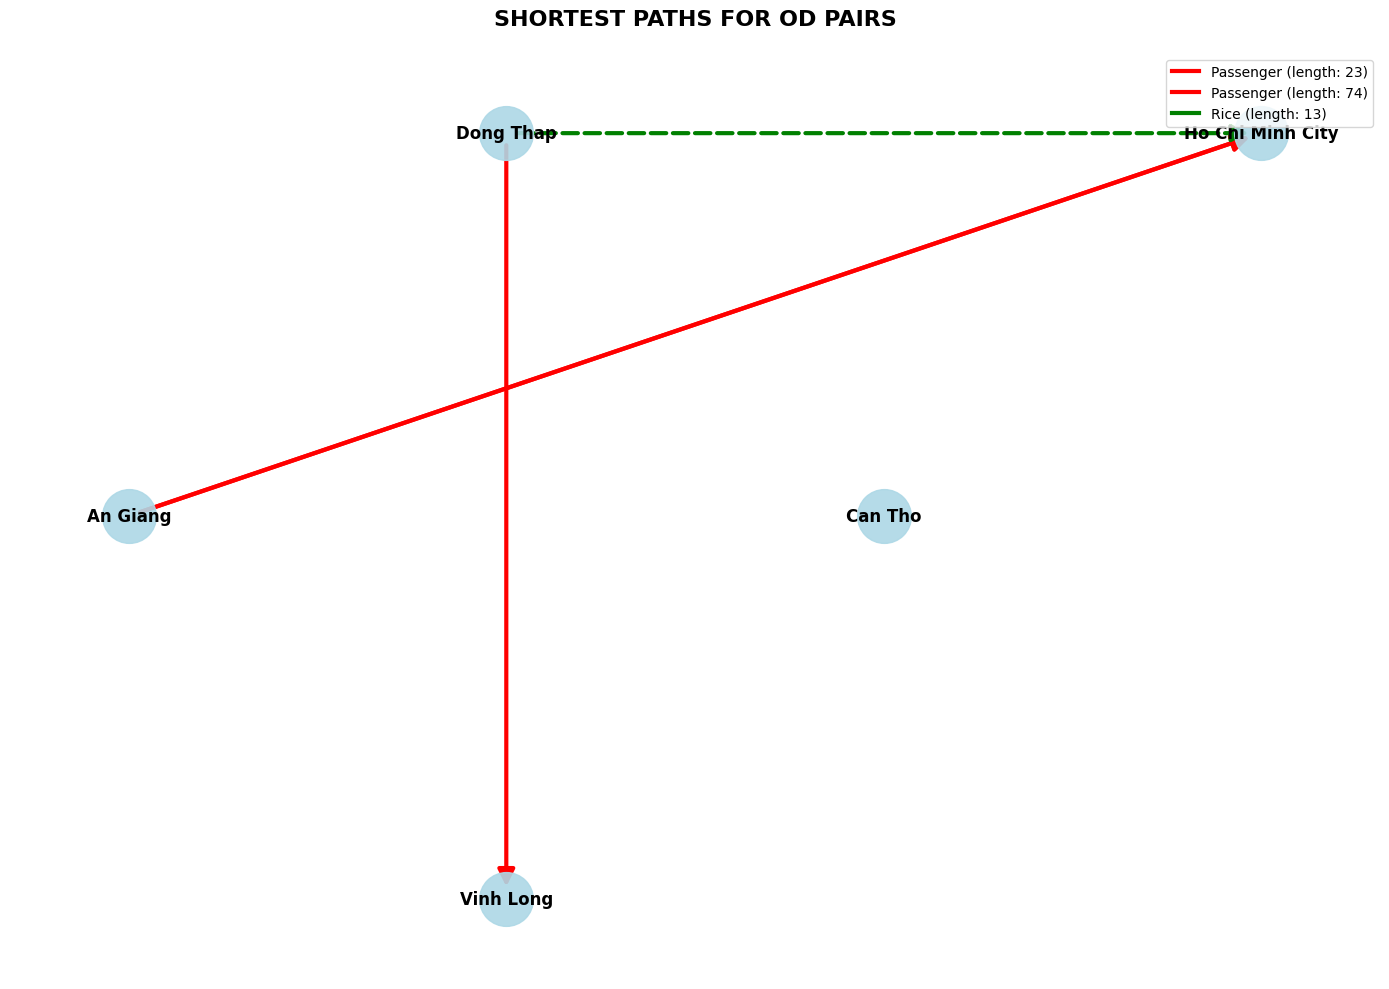

 FIND NEAR-SHORTEST PATHS (epsilon=0.5):
FIND SHORTEST PATHS FOR OD PAIRS:
Finding the shortest path from 0 to 3 for commodity g1
  Shortest path: [(0, 1), (3, 1)]
  Length: 23
Finding the shortest path from 1 to 4 for commodity g1
  Shortest path: [(1, 1), (4, 1)]
  Length: 74
Finding the shortest path from 1 to 3 for commodity g2
  Shortest path: [(1, 1), (3, 1)]
  Length: 13
 Finding near-shortest paths from 0 to 3 for commodity g1
  Shortest path length: 23
  Near-optimal threshold: 34.50
  Found 2 near-shortest paths
  Path 1: Length 23, Ratio compared to shortest: 1.000
  Path 2: Length 23, Ratio compared to shortest: 1.000
 Finding near-shortest paths from 1 to 4 for commodity g1
  Shortest path length: 74
  Near-optimal threshold: 111.00
  Found 12 near-shortest paths
  Path 1: Length 74, Ratio compared to shortest: 1.000
  Path 2: Length 74, Ratio compared to shortest: 1.000
  Path 3: Length 80, Ratio compared to shortest: 1.081
  Path 4: Length 80, Ratio compared to shortest:

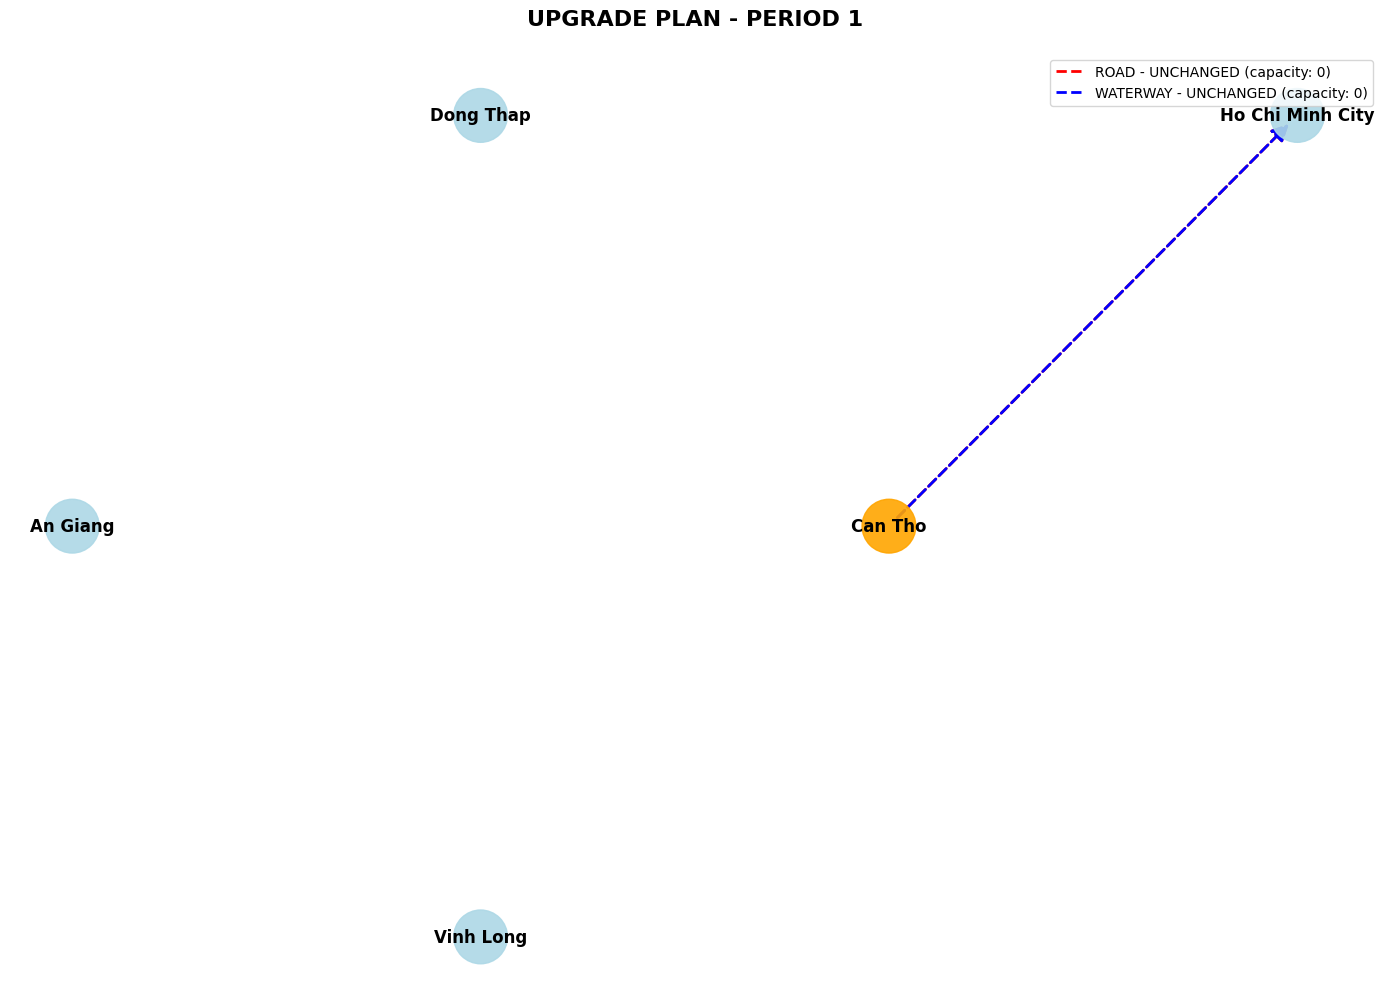

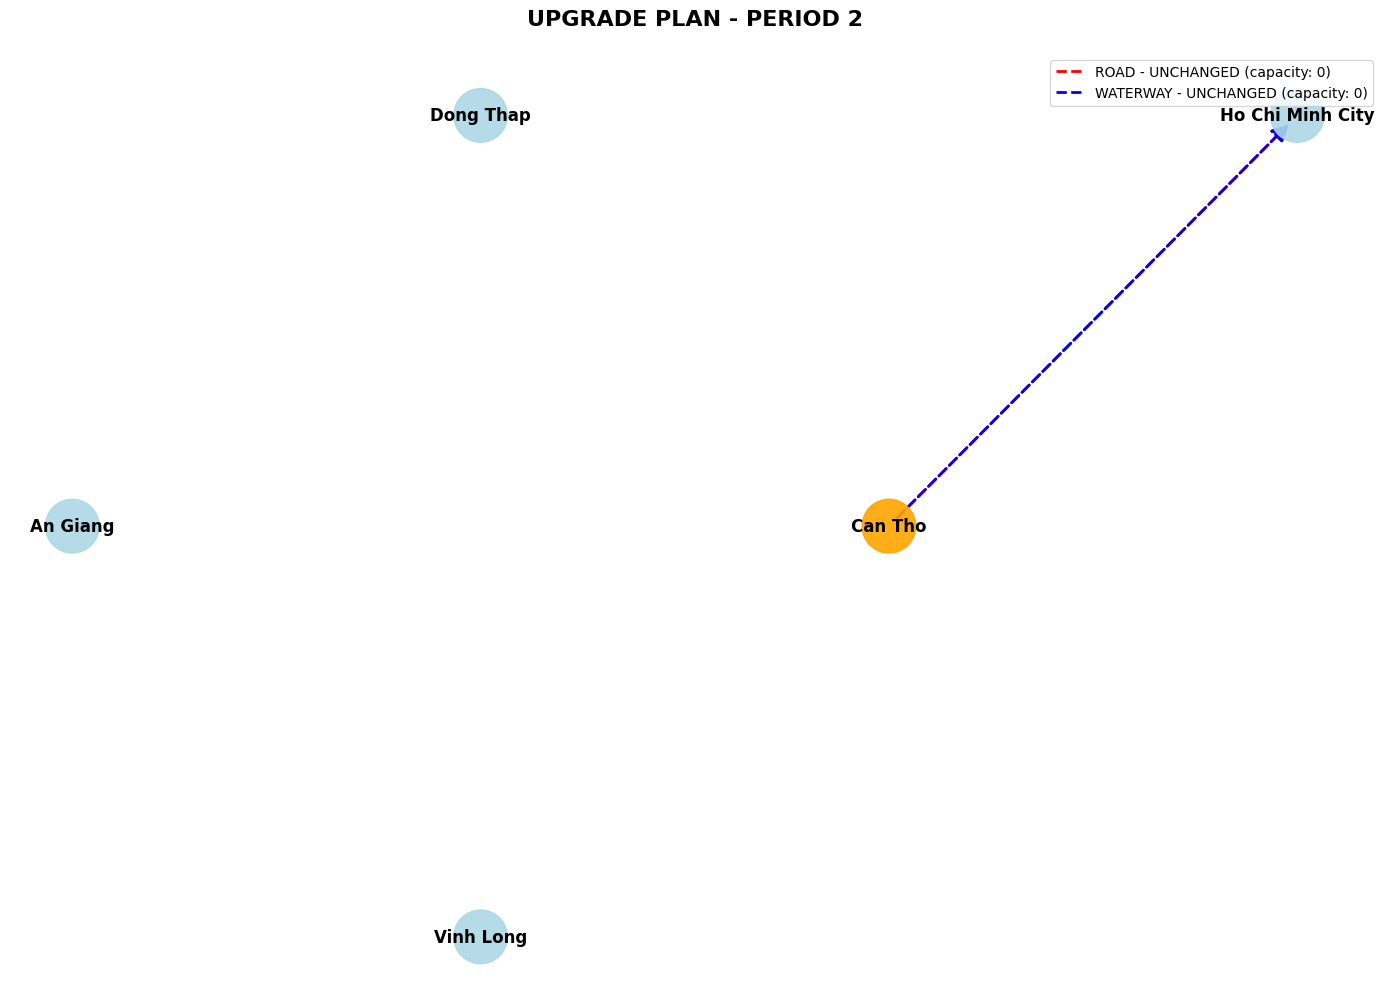

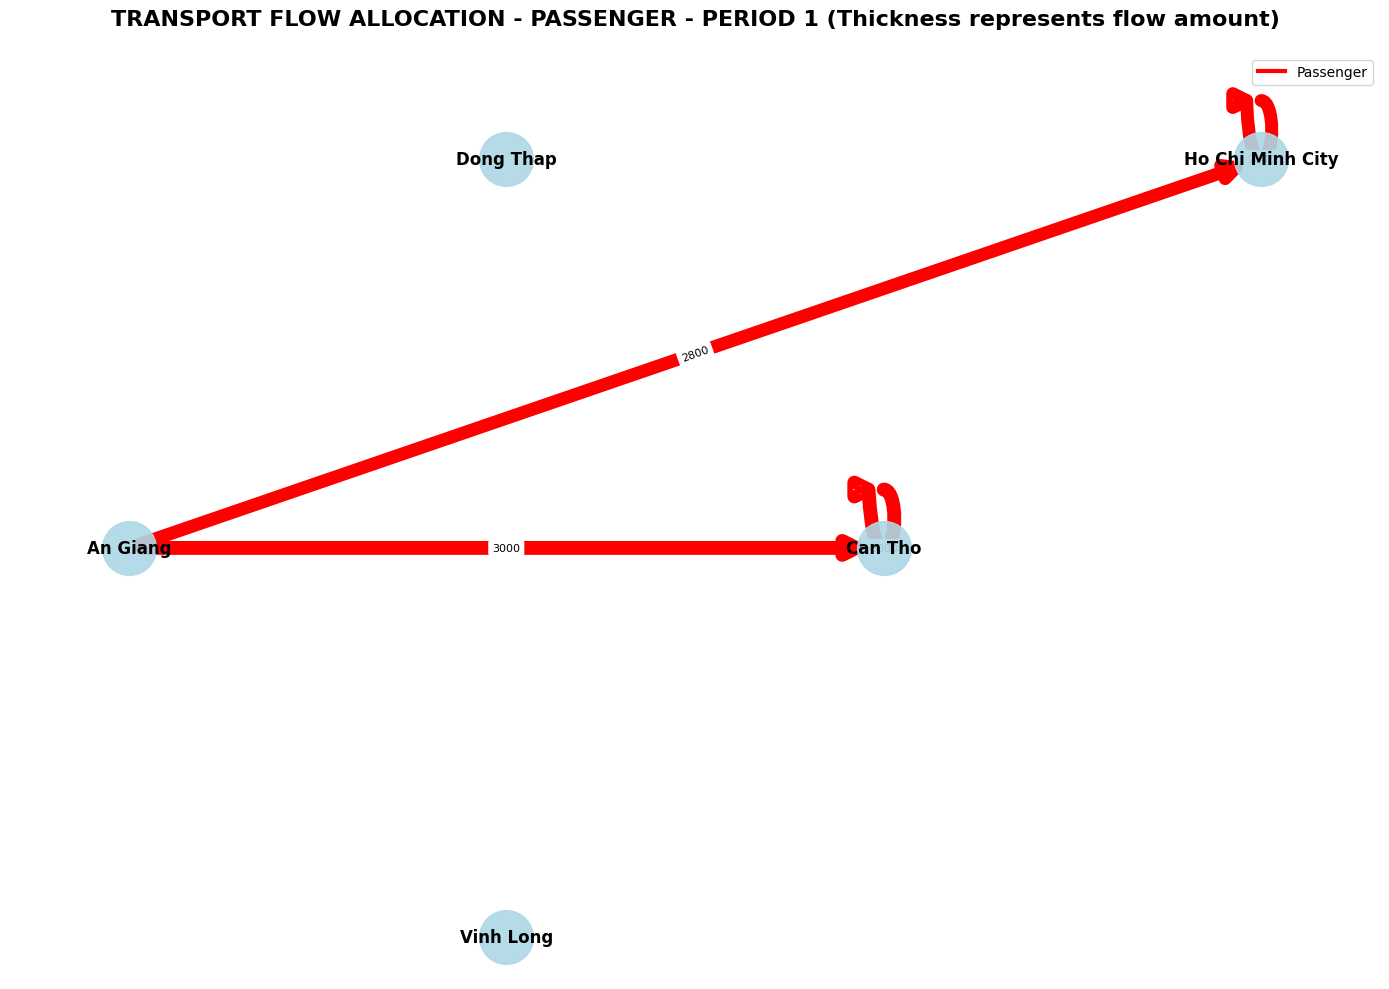

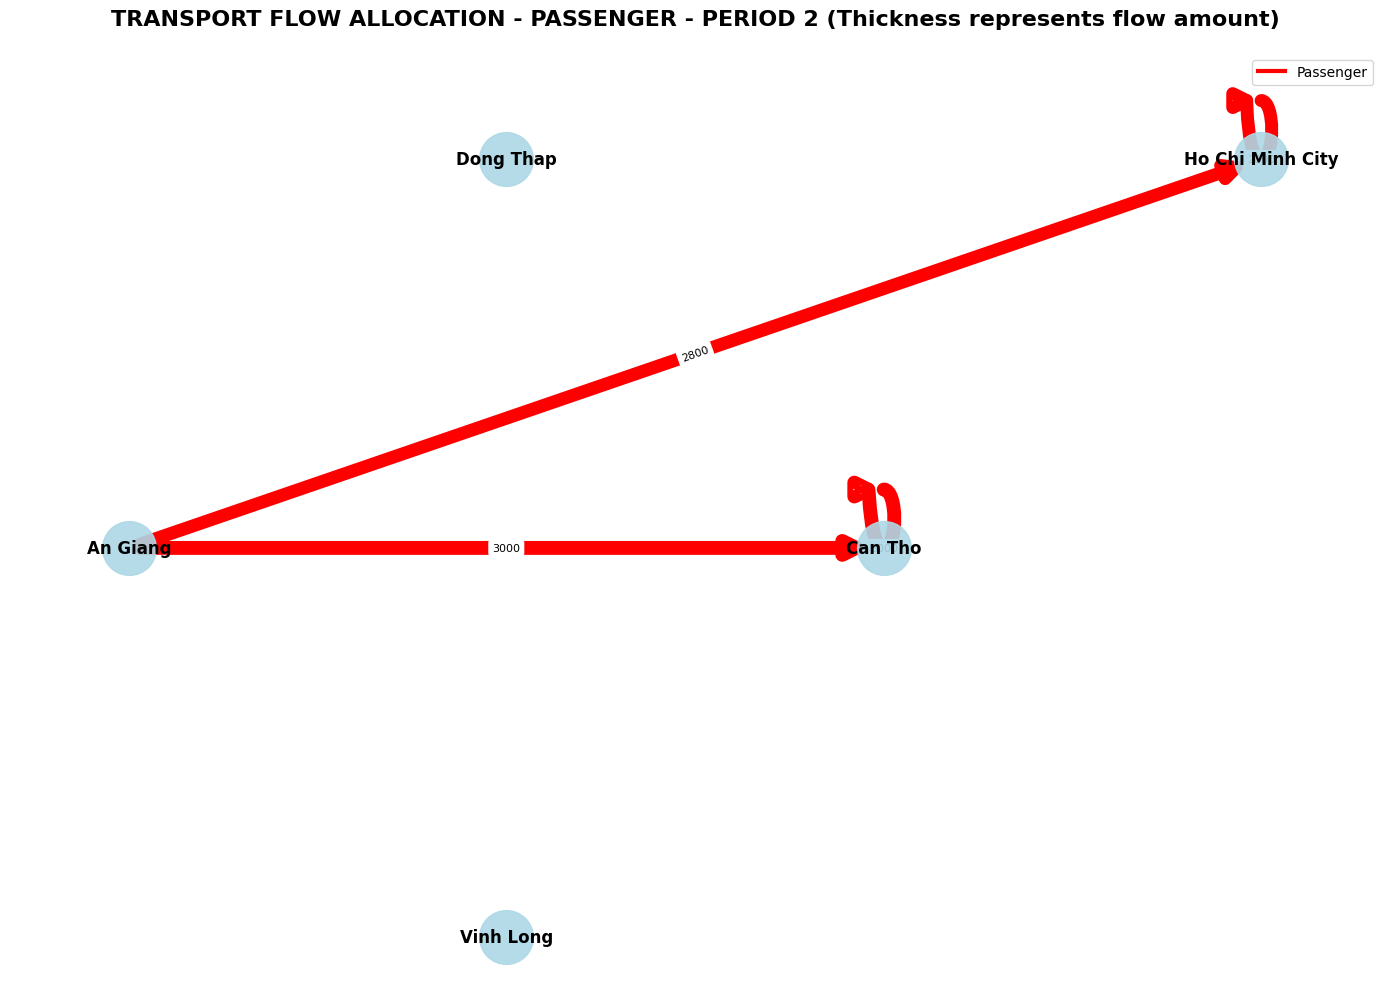

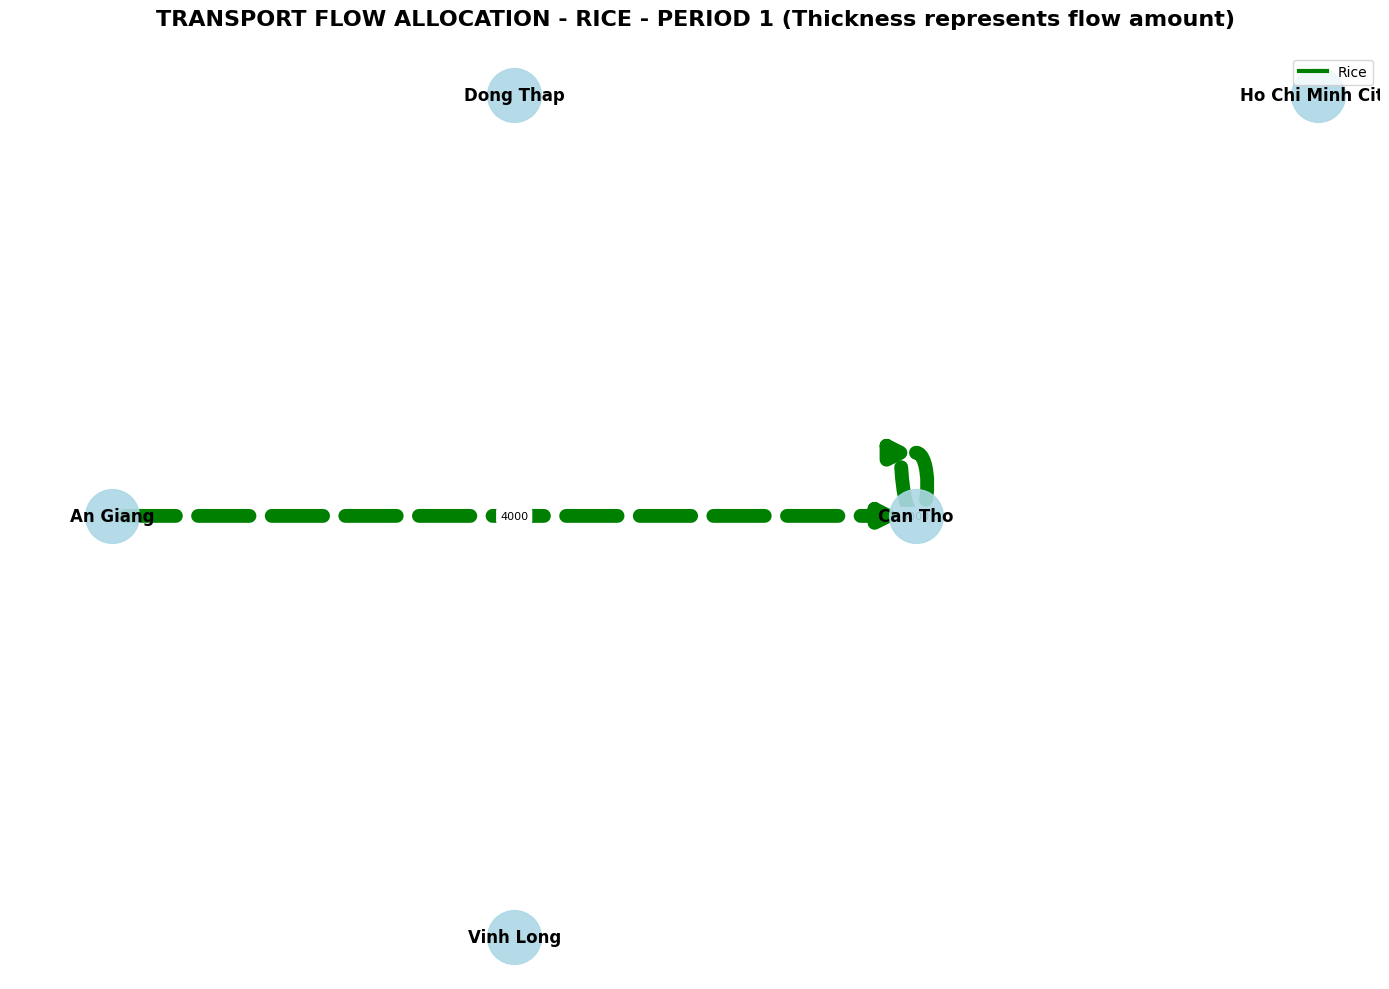

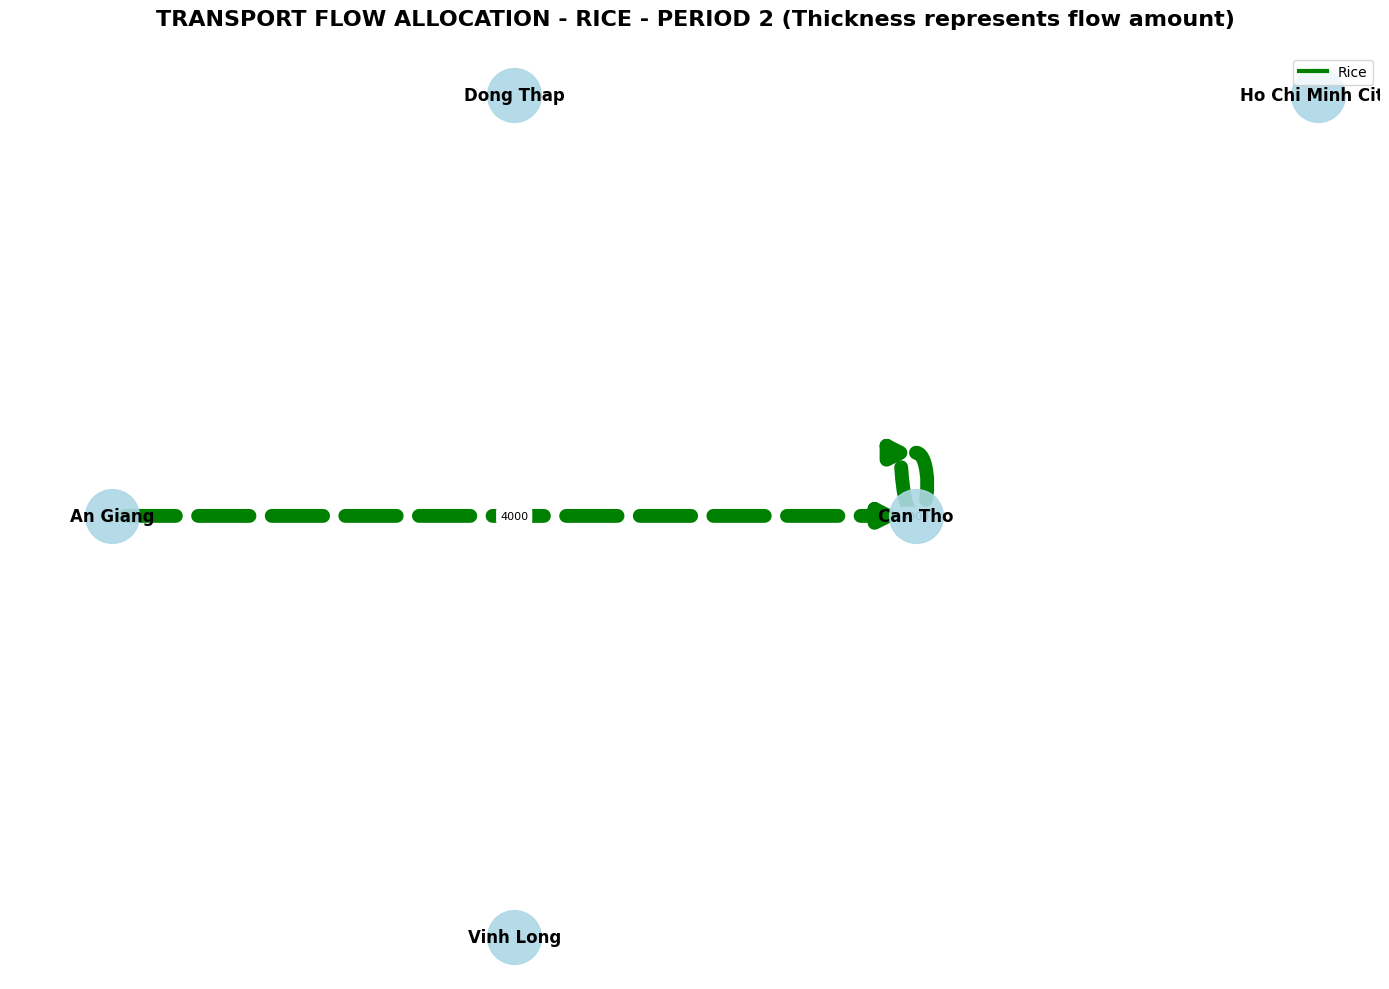

PROGRAM COMPLETED!


In [46]:
# ======== MAIN FUNCTION ========

def main():
    """Execute the full optimization workflow"""

    print("START MULTIMODAL TRANSPORT NETWORK OPTIMIZATION PROGRAM")
    print("=" * 60)

    # STEP 1 & 2: Process input data
    print(" STEP 1 & 2: PROCESS INPUT DATA")
    print("-" * 40)

    n_physical, edges, OD_pairs_physical = process_input_data()
    G_exp, _ = build_expanded_graph(n_physical, edges)

    print(f"Number of physical nodes: {n_physical}")
    print(f"Number of arcs: {len(edges)}")
    print(f"Number of OD pairs: {sum(len(od_list) for od_list in OD_pairs_physical.values())}")

    print(" Drawing the baseline network...")
    draw_original_network(n_physical, edges)

    # STEP 3: Find shortest and near-optimal paths
    print("STEP 3: FIND SHORTEST AND NEAR-OPTIMAL PATHS")
    print("-" * 40)

    shortest_paths = find_shortest_paths(G_exp, n_physical, OD_pairs_physical)
    print("Drawing shortest paths...")
    draw_shortest_paths(shortest_paths)

    all_paths_for_model, shortest_paths = find_near_optimal_paths(
        G_exp, n_physical, OD_pairs_physical
    )

    paths_adjusted = prepare_optimization_data(all_paths_for_model)

    # STEP 4: Build and solve the optimization model
    print(" STEP 4: BUILD AND SOLVE THE OPTIMIZATION MODEL")
    print("-" * 40)

    model, model_data = create_optimization_model(paths_adjusted)
    model, hub_investment, arc_investment, flow_allocation = solve_and_display_results(model, model_data)

    # STEP 5: Visualization
    print("STEP 5: VISUALIZATION")
    print("-" * 40)
    draw_upgrade_plan(hub_investment, arc_investment)
    draw_flow_distribution(flow_allocation, model_data['commodities'], model_data['T'])

    print("PROGRAM COMPLETED!")

if __name__ == "__main__":
    main()


Using Gorubi

In [54]:
import heapq
import time
import copy
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import gurobipy as gp
from gurobipy import GRB

# ======== STEP 1: FIND PATHS FOR OD PAIRS USING NEAR-OPTIMAL PATHS ========

def build_expanded_graph(n_physical, edges):
    """Build the expanded graph with virtual nodes"""
    G_exp = defaultdict(list)
    for u, v, mode, length in edges:
        if mode == 1:  # Road
            G_exp[(u, 1)].append(((v, 1), length))
            G_exp[(u, 1)].append(((v, 2), length))
        elif mode == 2:  # Waterway
            G_exp[(u, 2)].append(((v, 2), length))
            G_exp[(u, 2)].append(((v, 1), length))
    return G_exp, n_physical

def dijkstra_multi_target(G_exp, targets):
    """Run Dijkstra's algorithm with multiple targets"""
    dist = defaultdict(lambda: float('inf'))
    heap = []
    for target in targets:
        dist[target] = 0
        heapq.heappush(heap, (0, target))
    while heap:
        d, node = heapq.heappop(heap)
        if d != dist[node]:
            continue
        for neighbor, length in G_exp.get(node, []):
            new_dist = d + length
            if new_dist < dist[neighbor]:
                dist[neighbor] = new_dist
                heapq.heappush(heap, (new_dist, neighbor))
    return dist

def find_all_paths_dfs(G_exp, n_physical, s, t, max_paths=1_000_000, max_time=60):
    """Enumerate all paths using DFS"""
    start_time = time.time()
    results = []
    for start_type in [1, 2]:  # Try both starting modes
        visited_physical = [False] * n_physical
        visited_physical[s] = True
        stack = [((s, start_type), 0, [], visited_physical)]
        while stack:
            if time.time() - start_time > max_time or len(results) >= max_paths:
                return results
            node, total_length, path, visited = stack.pop()
            u, _ = node
            if u == t:
                results.append((path + [node], total_length))
                continue
            for next_node, length in G_exp.get(node, []):
                v, _ = next_node
                if not visited[v]:
                    new_path = path + [node]
                    new_length = total_length + length
                    new_visited = visited.copy()
                    new_visited[v] = True
                    stack.append((next_node, new_length, new_path, new_visited))
    return results

# ======== STEP 2: PROCESS INPUT DATA ========

def process_input_data():
    """Process and prepare the input data"""
    n_physical = 5
    edges = [
        (0, 2, 1, 45), (0, 2, 2, 41),
        (0, 3, 1, 23), (0, 3, 2, 96),
        (1, 2, 1, 85),
        (1, 3, 1, 13), (1, 3, 2, 21),
        (1, 4, 1, 74), (1, 4, 2, 87),
        (2, 3, 1, 35), (2, 3, 2, 93),
        (3, 4, 1, 67), (3, 4, 2, 85)
    ]
    OD_pairs_physical = {
        'g1': [(0, 3), (1, 4)],  # Passenger
        'g2': [(1, 3)]           # Rice
    }
    return n_physical, edges, OD_pairs_physical

# ======== STEP 3: FIND ALL NEAR-OPTIMAL PATHS ========

def find_near_optimal_paths(G_exp, n_physical, OD_pairs_physical):
    """Find all near-optimal paths for OD pairs"""
    all_paths_for_model = {}
    print("STEP 3: FIND ALL NEAR-OPTIMAL PATHS")
    print("=" * 50)
    for commodity, od_list in OD_pairs_physical.items():
        for od_pair in od_list:
            s, t = od_pair
            print(f" Finding paths from {s} to {t} for commodity {commodity}")
            paths = find_all_paths_dfs(G_exp, n_physical, s, t, max_paths=1000, max_time=30)
            print(f"  Found {len(paths)} paths")
            for i, (path, length) in enumerate(paths):
                print(f"  Path {i+1}: {path} - Length: {length}")
            all_paths_for_model[(commodity, (s, t))] = paths
    return all_paths_for_model

# ======== STEP 4: CONVERT PATHS TO VIRTUAL ARCS AND SOLVE THE OPTIMIZATION MODEL ========

def convert_path_to_model_format(path, length):
    """Convert a path from the expanded format to the model format"""
    arcs = []
    for i in range(len(path) - 1):
        u, u_mode = path[i]
        v, v_mode = path[i + 1]
        real_arc = (u, f"{v}^{v_mode}")
        arcs.append(real_arc)
        if i < len(path) - 2:
            virtual_arc = (f"{v}^{v_mode}", v)
            arcs.append(virtual_arc)
    last_node, last_mode = path[-1]
    virtual_arc_dest = (f"{last_node}^{last_mode}", last_node)
    arcs.append(virtual_arc_dest)
    return arcs, length

def prepare_optimization_data(all_paths_for_model):
    """Prepare data for the optimization model"""
    paths_converted = {}
    for key, path_list in all_paths_for_model.items():
        converted_paths = []
        for path, length in path_list:
            model_path, path_length = convert_path_to_model_format(path, length)
            converted_paths.append((model_path, path_length))
        paths_converted[key] = converted_paths
    paths_adjusted = {}
    for (commodity, orig_od), path_list in paths_converted.items():
        orig_s, orig_t = orig_od
        new_od = (orig_s + 1, orig_t + 1)
        paths_adjusted[(commodity, new_od)] = path_list
    return paths_adjusted

def create_optimization_model_gurobi(paths_adjusted):
    """Create and solve the optimization model with Gurobi"""
    T = [1, 2]
    real_nodes = [1, 2, 3, 4, 5]
    virtual_nodes = ['3^1', '3^2', '4^1', '4^2', '5^1', '5^2']
    H = [3]
    potential_hubs = [3]
    real_arcs = []
    virtual_arcs = []
    for path_list in paths_adjusted.values():
        for path, _ in path_list:
            for arc in path:
                if '^' in str(arc[1]):
                    if arc not in real_arcs:
                        real_arcs.append(arc)
                else:
                    if arc not in virtual_arcs:
                        virtual_arcs.append(arc)
    print(f"Real arcs: {real_arcs}")
    print(f"Virtual arcs: {virtual_arcs}")
    A = real_arcs + virtual_arcs
    potential_arcs = [(3, '4^1'), (3, '4^2')]
    existing_arcs = [arc for arc in A if arc not in potential_arcs]
    commodities = {'passenger': 'g1', 'rice': 'g2'}
    OD_pairs = {
        'g1': [(1, 4), (2, 5)],
        'g2': [(2, 4)]
    }
    arc_costs = {arc: 1 for arc in real_arcs}
    arc_costs.update({arc: 0 for arc in virtual_arcs})
    switch_cost = 2
    hub_service_cost = {3: 1}
    hub_upgrade_cost = 1000
    hub_capacity = {0: 2000, 1: 7000}
    arc_upgrade_costs = {(3, '4^1'): 800, (3, '4^2'): 500}
    arc_capacities = {
        (3, '4^1'): {0: 0, 1: 3000},
        (3, '4^2'): {0: 0, 1: 4000}
    }
    existing_arc_capacity = 2000
    demands = {
        ('g1', (1, 4)): 3000,
        ('g1', (2, 5)): 2800,
        ('g2', (2, 4)): 4000
    }
    model = gp.Model("Multimodal_Transport_Network_Optimization")
    y_hub = {(h, l, t): model.addVar(vtype=GRB.BINARY, name=f"y_hub_{h}_{l}_{t}")
             for h in potential_hubs for l in [0, 1] for t in T}
    y_arc = {(a[0], a[1], l, t): model.addVar(vtype=GRB.BINARY, name=f"y_arc_{a[0]}_{a[1]}_{l}_{t}")
             for a in potential_arcs for l in [0, 1] for t in T}
    v_path = {}
    for g, od_pairs in OD_pairs.items():
        for od in od_pairs:
            for idx, _ in enumerate(paths_adjusted[(g, od)]):
                for t in T:
                    v_path[(g, od, idx, t)] = model.addVar(lb=0, ub=1, name=f"v_{g}_{od[0]}_{od[1]}_p{idx+1}_t{t}")
    u_hub = {(h, t): model.addVar(lb=0, name=f"u_hub_{h}_{t}") for h in H for t in T}
    x_arc = {(a[0], a[1], t): model.addVar(lb=0, name=f"x_arc_{a[0]}_{a[1]}_{t}") for a in A for t in T}
    model.update()
    investment_cost = gp.quicksum(hub_upgrade_cost * hub_capacity[l] * y_hub[(h, l, t)]
                                  for h in potential_hubs for l in [0, 1] for t in T)         + gp.quicksum(arc_upgrade_costs[a] * arc_capacities[a][l] * y_arc[(a[0], a[1], l, t)]
                      for a in potential_arcs for l in [0, 1] for t in T)
    service_cost = gp.quicksum(hub_service_cost[h] * u_hub[(h, t)] for h in H for t in T)
    transport_cost = gp.quicksum(0)
    for g, od_pairs in OD_pairs.items():
        for od in od_pairs:
            demand = demands[(g, od)]
            for idx, (path, _) in enumerate(paths_adjusted[(g, od)]):
                path_cost = 0
                mode_switches = 0
                prev_mode = None
                for arc in path:
                    path_cost += arc_costs[arc]
                    current_mode = 'road' if str(arc[1]).endswith('^1') else 'water'
                    if prev_mode and prev_mode != current_mode:
                        mode_switches += 1
                    prev_mode = current_mode
                path_cost += mode_switches * switch_cost
                for t in T:
                    transport_cost += path_cost * demand * v_path[(g, od, idx, t)]
    model.setObjective(investment_cost + service_cost + transport_cost, GRB.MINIMIZE)
    for g, od_pairs in OD_pairs.items():
        for od in od_pairs:
            for t in T:
                model.addConstr(gp.quicksum(v_path[(g, od, idx, t)]
                                            for idx in range(len(paths_adjusted[(g, od)]))) == 1)
    for h in H:
        for t in T:
            total_flow = gp.quicksum(
                demands[(g, od)] * v_path[(g, od, idx, t)]
                for g, od_pairs in OD_pairs.items()
                for od in od_pairs
                for idx, (path, _) in enumerate(paths_adjusted[(g, od)])
                if any(arc[1] == str(h) or arc[1] == h for arc in path)
            )
            model.addConstr(u_hub[(h, t)] == total_flow)
    for arc in A:
        for t in T:
            total_flow = gp.quicksum(
                demands[(g, od)] * v_path[(g, od, idx, t)]
                for g, od_pairs in OD_pairs.items()
                for od in od_pairs
                for idx, (path, _) in enumerate(paths_adjusted[(g, od)])
                if arc in path
            )
            model.addConstr(x_arc[(arc[0], arc[1], t)] == total_flow)
    for h in potential_hubs:
        for t in T:
            model.addConstr(u_hub[(h, t)] <= gp.quicksum(hub_capacity[l] * y_hub[(h, l, t)]
                                                         for l in [0, 1]))
    for a in potential_arcs:
        for t in T:
            model.addConstr(x_arc[(a[0], a[1], t)] <= gp.quicksum(arc_capacities[a][l] * y_arc[(a[0], a[1], l, t)]
                                                                  for l in [0, 1]))
    for a in existing_arcs:
        if a in real_arcs:
            for t in T:
                model.addConstr(x_arc[(a[0], a[1], t)] <= existing_arc_capacity)
    for h in potential_hubs:
        for t in T:
            model.addConstr(gp.quicksum(y_hub[(h, l, t)] for l in [0, 1]) == 1)
    for a in potential_arcs:
        for t in T:
            model.addConstr(gp.quicksum(y_arc[(a[0], a[1], l, t)] for l in [0, 1]) == 1)
    for h in potential_hubs:
        for idx, t in enumerate(T[:-1]):
            t_next = T[idx + 1]
            model.addConstr(gp.quicksum(hub_capacity[l] * y_hub[(h, l, t_next)] for l in [0, 1])                              >= gp.quicksum(hub_capacity[l] * y_hub[(h, l, t)] for l in [0, 1]))
    for a in potential_arcs:
        for idx, t in enumerate(T[:-1]):
            t_next = T[idx + 1]
            model.addConstr(gp.quicksum(arc_capacities[a][l] * y_arc[(a[0], a[1], l, t_next)] for l in [0, 1])                              >= gp.quicksum(arc_capacities[a][l] * y_arc[(a[0], a[1], l, t)] for l in [0, 1]))
    return model, {
        'y_hub': y_hub,
        'y_arc': y_arc,
        'v_path': v_path,
        'u_hub': u_hub,
        'x_arc': x_arc,
        'OD_pairs': OD_pairs,
        'paths_adjusted': paths_adjusted,
        'demands': demands,
        'commodities': commodities,
        'potential_hubs': potential_hubs,
        'potential_arcs': potential_arcs,
        'T': T,
        'real_nodes': real_nodes,
        'virtual_nodes': virtual_nodes,
        'model': model
    }

def solve_and_display_results_gurobi(model, data):
    """Solve the Gurobi model and display the results"""
    print("" + "=" * 50)
    print("START SOLVING THE OPTIMIZATION MODEL WITH GUROBI")
    print("=" * 50)
    model.setParam('OutputFlag', 1)
    model.setParam('TimeLimit', 600)
    model.optimize()
    if model.status != GRB.OPTIMAL:
        print("No optimal solution found!")
        return None
    print(f"Solution status: {model.status}")
    print(f"Optimal total cost: {model.objVal:.2f}")
    def get_province_name(node_id):
        names = {
            1: "An Giang",
            2: "Dong Thap",
            3: "Can Tho",
            4: "Ho Chi Minh City",
            5: "Vinh Long"
        }
        return names.get(node_id, f"Node {node_id}")
    print("OPTIMAL RESULTS:")
    print("[1] HUB UPGRADE PLAN:")
    for h in data['potential_hubs']:
        for t in data['T']:
            for l in [0, 1]:
                if data['y_hub'][(h, l, t)].X > 0.5:
                    capacity = 2000 if l == 0 else 7000
                    action = "UPGRADE" if l == 1 else "UNCHANGED"
                    print(f"  Hub {get_province_name(h)} - Period {t}: {action} (capacity: {capacity})")
    print(" [2] ARC UPGRADE PLAN:")
    for a in data['potential_arcs']:
        for t in data['T']:
            for l in [0, 1]:
                if data['y_arc'][(a[0], a[1], l, t)].X > 0.5:
                    capacity = 0 if l == 0 else (3000 if '^1' in a[1] else 4000)
                    mode = "ROAD" if '^1' in a[1] else "WATERWAY"
                    action = "UPGRADE" if l == 1 else "UNCHANGED"
                    print(f"  Arc {get_province_name(a[0])}->{a[1].split('^')[0]} ({mode}) - Period {t}: {action} (capacity: {capacity})")
    print("[3] TRANSPORT FLOW ALLOCATION:")
    for g_name, g_code in data['commodities'].items():
        print(f"Commodity: {g_name.upper()}")
        for od in data['OD_pairs'][g_code]:
            origin, dest = od
            print(f"    Route: {get_province_name(origin)} -> {get_province_name(dest)}")
            for t in data['T']:
                print(f"      Period {t}:")
                total_flow = 0
                for idx, (path, _) in enumerate(data['paths_adjusted'][(g_code, od)]):
                    flow_value = data['v_path'][(g_code, od, idx, t)].X
                    if flow_value > 0.001:
                        flow_amount = data['demands'][(g_code, od)] * flow_value
                        total_flow += flow_amount
                        path_desc = " -> ".join([f"{arc[0]}->{arc[1]}" for arc in path])
                        print(f"        Path {idx+1}: {flow_amount:.2f} units")
                        print(f"          Route: {path_desc}")
                print(f"        Total flow: {total_flow:.2f}")
    print("[4] COST SUMMARY:")
    investment_cost = gp.quicksum(
        1000 * (2000 if l == 0 else 7000) * data['y_hub'][(h, l, t)].X
        for h in data['potential_hubs'] for l in [0, 1] for t in data['T'] ).getValue() + gp.quicksum(
        ({(3, '4^1'): 800, (3, '4^2'): 500}[a] * ({0: 0, 1: 3000} if '^1' in a[1] else {0: 0, 1: 4000})[l] * data['y_arc'][(a[0], a[1], l, t)].X)
        for a in data['potential_arcs'] for l in [0, 1] for t in data['T'] ).getValue()
    service_cost = gp.quicksum( 1 * data['u_hub'][(h, t)].X for h in [3] for t in data['T']).getValue()
    transport_cost = gp.quicksum(0)
    for g, od_pairs in data['OD_pairs'].items():
        for od in od_pairs:
            demand = data['demands'][(g, od)]
            for idx, (path, _) in enumerate(data['paths_adjusted'][(g, od)]):
                path_cost = 0
                mode_switches = 0
                prev_mode = None
                for arc in path:
                    path_cost += (1 if '^' in str(arc[1]) else 0)
                    current_mode = 'road' if str(arc[1]).endswith('^1') else 'water'
                    if prev_mode and prev_mode != current_mode:
                        mode_switches += 1
                    prev_mode = current_mode
                path_cost += mode_switches * 2
                for t in data['T']:
                    transport_cost += path_cost * demand * data['v_path'][(g, od, idx, t)].X
    transport_cost_value = transport_cost.getValue()
    print(f"  Investment cost: {investment_cost:.2f}")
    print(f"  Hub service cost: {service_cost:.2f}")
    print(f"  Transport cost: {transport_cost_value:.2f}")
    print(f"  TOTAL: {model.objVal:.2f}")
    return model

# ======== STEP 5: VISUALIZATION ========

def visualize_network_flows_gurobi(data, model):
    """Visualize flow allocations for each commodity using the Gurobi results"""
    def get_province_name(node_id):
        names = {
            0: "An Giang",
            1: "An Giang",
            2: "Dong Thap",
            3: "Can Tho",
            4: "Ho Chi Minh City",
            5: "Vinh Long"
        }
        return names.get(node_id, f"Node {node_id}")
    for commodity_name, commodity_code in data['commodities'].items():
        G = nx.DiGraph()
        for node in range(6):
            G.add_node(node, label=get_province_name(node), type='real')
        for node in ['3^1', '3^2', '4^1', '4^2', '5^1', '5^2']:
            G.add_node(node, label=node, type='virtual')
        edge_flows = {}
        print(f" Calculating flows for {commodity_name}...")
        for od in data['OD_pairs'][commodity_code]:
            print(f"  Processing OD: {od}")
            demand = data['demands'][(commodity_code, od)]
            for t in data['T']:
                for idx, (path, path_length) in enumerate(data['paths_adjusted'][(commodity_code, od)]):
                    flow_value = data['v_path'][(commodity_code, od, idx, t)].X
                    if flow_value is not None and flow_value > 0.001:
                        flow_amount = demand * flow_value
                        for arc in path:
                            u, v = arc
                            if isinstance(u, int) and u > 5:
                                u -= 1
                            if isinstance(v, str) and '^' in v:
                                pass
                            elif isinstance(v, int) and v > 5:
                                v -= 1
                            edge_flows[(u, v)] = edge_flows.get((u, v), 0) + flow_amount
        for (u, v), flow in edge_flows.items():
            G.add_edge(u, v, weight=flow)
            print(f"  Arc {u} -> {v}: {flow:.2f}")
        if not G.edges():
            print(f"No flow for commodity {commodity_name}")
            continue
        plt.figure(figsize=(14, 10))
        pos = {
            0: (0, 2),
            1: (2, 3),
            2: (4, 2),
            3: (6, 3),
            4: (2, 1),
            5: (2, 1),
            '3^1': (3.5, 2.3),
            '3^2': (4.5, 1.7),
            '4^1': (5.5, 2.8),
            '4^2': (6.5, 3.2),
            '5^1': (1.8, 1.3),
            '5^2': (2.2, 0.7)
        }
        missing_nodes = [node for node in G.nodes() if node not in pos]
        if missing_nodes:
            print(f"Warning: nodes missing from layout: {missing_nodes}")
            for i, node in enumerate(missing_nodes):
                pos[node] = (i * 2, 0)
        real_nodes = [node for node in G.nodes() if G.nodes[node].get('type') == 'real']
        virtual_nodes = [node for node in G.nodes() if G.nodes[node].get('type') == 'virtual']
        if real_nodes:
            nx.draw_networkx_nodes(G, pos, nodelist=real_nodes,
                                   node_color='lightblue', node_size=1000,
                                   alpha=0.9, edgecolors='darkblue', linewidths=2)
        if virtual_nodes:
            nx.draw_networkx_nodes(G, pos, nodelist=virtual_nodes,
                                   node_color='lightgreen', node_size=600,
                                   alpha=0.7, node_shape='s', edgecolors='darkgreen', linewidths=1)
        valid_edges = []
        widths = []
        colors = []
        for (u, v), flow in edge_flows.items():
            if u in pos and v in pos:
                valid_edges.append((u, v))
                widths.append(max(0.5, flow / 500))
                if '^1' in str(v):
                    colors.append('red')
                elif '^2' in str(v):
                    colors.append('blue')
                else:
                    colors.append('green')
            else:
                print(f"Warning: skipping edge {u}->{v} because a node is missing from the layout")
        if not valid_edges:
            print("Warning: no valid edges to draw")
            plt.close()
            continue
        nx.draw_networkx_edges(G, pos, edgelist=valid_edges,
                               width=widths, alpha=0.7,
                               edge_color=colors, arrows=True,
                               arrowsize=20, arrowstyle='->')
        labels = {}
        for node in G.nodes():
            if node in real_nodes:
                labels[node] = get_province_name(node)
            elif '^' in str(node):
                base_node, mode = str(node).split('^')
                labels[node] = f"V{base_node}({mode})"
            else:
                labels[node] = str(node)
        nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight='bold')
        edge_labels = {(u, v): f"{G[u][v]['weight']:.0f}" for u, v in valid_edges}
        nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)
        legend_elements = [
            plt.Line2D([0], [0], color='red', lw=2, label='Road'),
            plt.Line2D([0], [0], color='blue', lw=2, label='Waterway'),
            plt.Line2D([0], [0], color='green', lw=2, label='Virtual arc'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue',
                       markersize=10, label='Province/City'),
            plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='lightgreen',
                       markersize=10, label='Virtual node')
        ]
        plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1))
        plt.title( f"TRANSPORT FLOW ALLOCATION - {commodity_name.upper()} "
            f"(Edge thickness indicates flow amount)",
            fontsize=16, fontweight='bold', pad=20
        )
        plt.axis('off')
        plt.tight_layout()
        filename = f'network_flow_{commodity_name}_gurobi.png'
        print(f"Saved chart: {filename}")
        plt.show()

# ======== MAIN FUNCTION AND OUTPUT ========

def main_gurobi():
    """Run the full workflow with Gurobi"""
    print("START MULTIMODAL TRANSPORT NETWORK OPTIMIZATION PROGRAM WITH GUROBI")
    print("=" * 60)
    print("STEP 1: FIND PATHS FOR OD PAIRS")
    print("-" * 40)
    n_physical, edges, OD_pairs_physical = process_input_data()
    G_exp, _ = build_expanded_graph(n_physical, edges)
    print("Expanded graph constructed successfully")
    print("STEP 2: PROCESS INPUT DATA")
    print("-" * 40)
    print(f"Number of physical nodes: {n_physical}")
    print(f"Number of arcs: {len(edges)}")
    print(f"Number of OD pairs: {sum(len(od_list) for od_list in OD_pairs_physical.values())}")
    all_paths_for_model = find_near_optimal_paths(G_exp, n_physical, OD_pairs_physical)
    print("STEP 3: CONVERT PATHS TO VIRTUAL ARCS AND SOLVE THE OPTIMIZATION MODEL WITH GUROBI")
    print("-" * 60)
    paths_adjusted = prepare_optimization_data(all_paths_for_model)
    model, model_data = create_optimization_model_gurobi(paths_adjusted)
    solved_model = solve_and_display_results_gurobi(model, model_data)
    if solved_model is None:
        print("Unable to solve the model. Exiting.")
        return
    print("STEP 4: VISUALIZE RESULTS")
    print("-" * 40)
    visualize_network_flows_gurobi(model_data, solved_model)
    print(" "+"=" * 60)
    print("PROGRAM COMPLETED!")
    print("=" * 60)

if __name__ == "__main__":
    main_gurobi()


START MULTIMODAL TRANSPORT NETWORK OPTIMIZATION PROGRAM WITH GUROBI
STEP 1: FIND PATHS FOR OD PAIRS
----------------------------------------
Expanded graph constructed successfully
STEP 2: PROCESS INPUT DATA
----------------------------------------
Number of physical nodes: 5
Number of arcs: 13
Number of OD pairs: 3
STEP 3: FIND ALL NEAR-OPTIMAL PATHS
 Finding paths from 0 to 3 for commodity g1
  Found 12 paths
  Path 1: [(0, 1), (3, 2)] - Length: 23
  Path 2: [(0, 1), (3, 1)] - Length: 23
  Path 3: [(0, 1), (2, 2), (3, 1)] - Length: 138
  Path 4: [(0, 1), (2, 2), (3, 2)] - Length: 138
  Path 5: [(0, 1), (2, 1), (3, 2)] - Length: 80
  Path 6: [(0, 1), (2, 1), (3, 1)] - Length: 80
  Path 7: [(0, 2), (3, 1)] - Length: 96
  Path 8: [(0, 2), (3, 2)] - Length: 96
  Path 9: [(0, 2), (2, 1), (3, 2)] - Length: 76
  Path 10: [(0, 2), (2, 1), (3, 1)] - Length: 76
  Path 11: [(0, 2), (2, 2), (3, 1)] - Length: 134
  Path 12: [(0, 2), (2, 2), (3, 2)] - Length: 134
 Finding paths from 1 to 4 for com

TypeError: 'int' object is not iterable

In [58]:
import pandas as pd
import heapq
from collections import defaultdict
import gurobipy as gp
from gurobipy import GRB
import networkx as nx

# ===================================================================
# STEP 1: READ AND PROCESS REAL DATA FROM EXCEL
# ===================================================================

def load_real_data(file_path='Transport_Corridors_MekongDelta.xlsx'):
    """Load nodes, arcs, and OD information from the Excel workbook"""
    arc_df = pd.read_excel(file_path, sheet_name='ARC-Net')
    node_df = pd.read_excel(file_path, sheet_name='Node')
    node_map = dict(zip(node_df['New_ID'], node_df['Project']))
    potential_hubs = [nid for nid, proj in node_map.items() if 'New' in str(proj) or 'Upgrade' in str(proj)]
    H = list(set(potential_hubs))
    n_physical = len(node_df)
    edges = []
    potential_arcs = []
    for _, row in arc_df.iterrows():
        u = row['From Node']
        v = row['To Node']
        typ = 1 if row['Type'] == 'R' else 2
        length = row['Length (m)'] / 1000.0
        proj = row['Project (P/E)']
        edges.append((u, v, typ, length))
        if proj != 'E':
            potential_arcs.append((u, v, typ))
        edges.append((v, u, typ, length))
    OD_pairs = {
        'passenger': [(0, 15), (0, 34), (0, 21)],
        'rice': [(11, 0), (13, 0), (14, 0), (15, 0), (27, 0), (3, 0)],
        'fisheries': [(30, 0), (31, 0), (32, 0), (33, 0), (34, 0), (21, 30), (21, 0), (19, 0), (19, 15), (14, 0)],
        'fruits': [(6, 0), (7, 0), (10, 0), (11, 0), (14, 0), (18, 0)]
    }
    demands = {(g, od): 1000 for g, od_list in OD_pairs.items() for od in od_list}
    return edges, OD_pairs, demands, H, potential_hubs, potential_arcs, n_physical

# ===================================================================
# STEP 2: BUILD THE EXPANDED GRAPH & FIND NEAR-OPTIMAL PATHS
# ===================================================================

def build_expanded_graph(edges, switch_cost=2):
    """Create the expanded graph, allowing mode switches"""
    G_exp = defaultdict(list)
    for u, v, mode, length in edges:
        if mode == 1:
            G_exp[(u, 1)].append(((v, 1), length))
            G_exp[(u, 1)].append(((v, 2), length + switch_cost))
        else:
            G_exp[(u, 2)].append(((v, 2), length))
            G_exp[(u, 2)].append(((v, 1), length + switch_cost))
    return G_exp

def dijkstra_multi_target(G_exp, targets):
    dist = defaultdict(lambda: float('inf'))
    heap = []
    for t in targets:
        dist[t] = 0
        heapq.heappush(heap, (0, t))
    while heap:
        d, node = heapq.heappop(heap)
        if d > dist[node]:
            continue
        for neigh, cost in G_exp[node]:
            nd = d + cost
            if nd < dist[neigh]:
                dist[neigh] = nd
                heapq.heappush(heap, (nd, neigh))
    return dist

def find_near_optimal_paths(G_exp, s, t, epsilon=0.5, max_paths=50):
    """Enumerate near-optimal paths between s and t"""
    dprime = dijkstra_multi_target(G_exp, [(t, 1), (t, 2)])
    Lmin = min(dprime.get((s, 1), float('inf')), dprime.get((s, 2), float('inf')))
    if Lmin == float('inf'):
        return []
    bound = (1 + epsilon) * Lmin
    results = []
    n_physical = max([u for u, _ in G_exp] + [0]) + 1
    for start_mode in [1, 2]:
        visited = [False] * n_physical
        visited[s] = True
        stack = [((s, start_mode), 0, [(s, start_mode)])]
        while stack and len(results) < max_paths:
            node, cost, path = stack.pop()
            u, _ = node
            if u == t:
                results.append((path, cost))
                continue
            for neigh, w in sorted(G_exp[node], key=lambda x: x[1]):
                v, _ = neigh
                if visited[v]:
                    continue
                new_cost = cost + w
                if new_cost + dprime[neigh] > bound:
                    continue
                new_path = path + [neigh]
                new_visited = visited[:]
                new_visited[v] = True
                stack.append((neigh, new_cost, new_path))
    return results[:max_paths]

# ===================================================================
# STEP 3: CREATE PATHS FOR ALL ODs
# ===================================================================

file_path = 'Transport_Corridors_MekongDelta.xlsx'
edges, OD_pairs, demands, H, potential_hubs, potential_arcs, n_physical = load_real_data(file_path)
G_exp = build_expanded_graph(edges)
all_paths = {}

print("FIND NEAR-OPTIMAL PATHS FOR REAL DATA")
print("=" * 60)
for g, pairs in OD_pairs.items():
    all_paths[g] = {}
    for s, t in pairs:
        paths = find_near_optimal_paths(G_exp, s, t)
        all_paths[g][(s, t)] = paths
        print(f"{g}: {s}->{t} -> {len(paths)} paths")

# ===================================================================
# STEP 4: SOLVE WITH GUROBI (3 PERIODS)
# ===================================================================

def solve_real_with_gurobi():
    model = gp.Model("Mekong_Real_MultiPeriod")
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 600
    T = [1, 2, 3]
    hub_capacity_levels = {0: 1000, 1: 5000}
    arc_capacity_levels = {0: 1000, 1: 5000}
    hub_upgrade_cost = 1000
    arc_upgrade_cost = {a: 500 for a in potential_arcs}
    switch_cost = 2
    service_cost = 1
    y_h = model.addVars(H, [0, 1], T, vtype=GRB.BINARY, name="y_hub")
    y_a = model.addVars(potential_arcs, [0, 1], T, vtype=GRB.BINARY, name="y_arc")
    v_p = {}
    cost_p = {}
    path_idx = 0
    for g, od_dict in all_paths.items():
        for (o, d), paths in od_dict.items():
            if not paths:
                continue
            dem = demands[(g, (o, d))]
            for path_nodes, path_cost in paths:
                var = model.addVar(lb=0, ub=1, name=f"v_{g}_{o}_{d}_{path_idx}")
                v_p[(g, o, d, path_idx)] = var
                cost_p[(g, o, d, path_idx)] = path_cost * dem
                path_idx += 1
    u_h = model.addVars(H, T, lb=0, name="u_hub")
    model.update()
    invest_hub = gp.quicksum(hub_upgrade_cost * hub_capacity_levels[l] * y_h[h, l, t] for h in H for l in [0, 1] for t in T)
    invest_arc = gp.quicksum(arc_upgrade_cost.get(a, 500) * arc_capacity_levels[l] * y_a[a, l, t] for a in potential_arcs for l in [0, 1] for t in T)
    service = gp.quicksum(service_cost * u_h[h, t] for h in H for t in T)
    transport = gp.quicksum(cost_p[k] * v_p[k] for k in v_p)
    model.setObjective(invest_hub + invest_arc + service + transport, GRB.MINIMIZE)
    for g, od_dict in all_paths.items():
        for (o, d), paths in od_dict.items():
            if paths:
                for t in T:
                    model.addConstr(gp.quicksum(v_p[(g, o, d, idx)] for idx in range(len(paths))) == 1)
    for h in H:
        for t in T:
            flow = gp.LinExpr()
            for g, od_dict in all_paths.items():
                for (o, dest), paths in od_dict.items():
                    if paths:
                        dem = demands[(g, (o, dest))]
                        for idx, (path, _) in enumerate(paths):
                            if any(node[0] == h for node in path):
                                flow += dem * v_p[(g, o, dest, idx)]
            model.addConstr(u_h[h, t] == flow)
    for h in H:
        for t in T:
            model.addConstr(u_h[h, t] <= gp.quicksum(hub_capacity_levels[l] * y_h[h, l, t] for l in [0, 1]))
    for a in potential_arcs:
        for t in T:
            flow_arc = gp.LinExpr()
            for g, od_dict in all_paths.items():
                for (o, d), paths in od_dict.items():
                    if paths:
                        dem = demands[(g, (o, d))]
                        for idx, (path, _) in enumerate(paths):
                            u = a[0]
                            m = a[2] if len(a) == 3 else 1
                            for i in range(len(path) - 1):
                                if path[i] == (u, m) and path[i + 1][0] == a[1]:
                                    flow_arc += dem * v_p[(g, o, d, idx)]
            model.addConstr(flow_arc <= gp.quicksum(arc_capacity_levels[l] * y_a[a, l, t] for l in [0, 1]))
    for h in H:
        for t in T:
            model.addConstr(gp.quicksum(y_h[h, l, t] for l in [0, 1]) == 1)
    for a in potential_arcs:
        for t in T:
            model.addConstr(gp.quicksum(y_a[a, l, t] for l in [0, 1]) == 1)
    model.optimize()
    if model.Status != GRB.OPTIMAL:
        print("Unable to find an optimal solution (try reducing max_paths or increasing the time limit)")
        return
    print(" " + "=" * 80)
    print(" " * 30 + "RESULTS WITH REAL DATA (MEKONG DELTA)")
    print("=" * 80)
    print(f" OPTIMAL TOTAL COST: {model.ObjVal:,.0f}")
    print("1. NETWORK DESCRIPTION (FROM EXCEL)")
    print("-" * 50)
    print(f"- Nodes: N = {n_physical} (from sheet Node, New_ID 0-{n_physical-1})")
    print(f"- Hubs: H = {len(H)} potential hubs: {H[:5]}{'...' if len(H) > 5 else ''} (Project: New/Upgrade)")
    print(f"- Arcs: |A| = {len(edges)//2} undirected arcs (bidirectional in ARC-Net)")
    print(f"- Commodities: G = {list(OD_pairs.keys())}")
    print(f"- OD pairs: total {sum(len(pairs) for pairs in OD_pairs.values())} pairs (from the data)")
    print("2. PARAMETERS (FROM EXCEL)")
    print("-" * 50)
    print("- Lengths: average {:.1f} km/arc".format(pd.DataFrame(edges)[3].mean()))
    print("- Types: {} R (road), {} W (water)".format(sum(1 for _, _, m, _ in edges if m == 1)//2, sum(1 for _, _, m, _ in edges if m == 2)//2))
    print(f"- Potential arcs: {len(potential_arcs)} (Project = P)")
    print("- Demands: 1000 units per OD pair")
    print("- Periods: T = {1,2,3} (15 years)")
    print("3. DETAILED UPGRADE TIMELINE")
    print("-" * 50)
    upgraded = []
    for h in H:
        for t in T:
            for l in [0, 1]:
                if y_h[h, l, t].X > 0.5 and l == 1:
                    upgraded.append(f"Hub {h} upgraded in period {t}")
    for a in potential_arcs:
        for t in T:
            for l in [0, 1]:
                if y_a[a, l, t].X > 0.5 and l == 1:
                    upgraded.append(f"Arc {a[0]}->{a[1]} upgraded in period {t}")
    for item in upgraded[:10]:
        print(f"- {item}")
    if len(upgraded) > 10:
        print(f"... and {len(upgraded) - 10} more")
    print("4. FLOW ALLOCATION (SAMPLE)")
    print("-" * 50)
    for g, od_dict in list(all_paths.items())[:2]:
        print(f" {g.upper()}:" )
        total_flow = 0
        for (o, d), paths in list(od_dict.items())[:2]:
            for t in T[:1]:
                used_flow = sum(demands[(g, (o, d))] * v_p.get((g, o, d, idx), gp.Var()).X for idx in range(min(3, len(paths))))
                total_flow += used_flow
                if used_flow > 0:
                    print(f"  {o}->{d} (Period {t}): {used_flow:,.0f} units")
        print(f"  Total {g}: {total_flow:,.0f}")
    print("5. OBJECTIVE BREAKDOWN")
    print("-" * 50)
    hub_cost = invest_hub.getValue()
    arc_cost = invest_arc.getValue()
    service_val = service.getValue()
    transport_val = transport.getValue()
    print(f"- Hub investment: {hub_cost:,.0f}")
    print(f"- Arc investment: {arc_cost:,.0f}")
    print(f"- Service: {service_val:,.0f}")
    print(f"- Transport: {transport_val:,.0f}")
    print(f"- TOTAL: {model.ObjVal:,.0f}")
    print(" " + "=" * 80)
    print(" " * 30 + "COMPLETED (REAL DATA)")
    print("=" * 80)

solve_real_with_gurobi()


FIND NEAR-OPTIMAL PATHS FOR REAL DATA
passenger: 0->15 -> 50 paths
passenger: 0->34 -> 50 paths
passenger: 0->21 -> 50 paths
rice: 11->0 -> 50 paths
rice: 13->0 -> 50 paths
rice: 14->0 -> 50 paths
rice: 15->0 -> 50 paths
rice: 27->0 -> 50 paths
rice: 3->0 -> 2 paths
fisheries: 30->0 -> 50 paths
fisheries: 31->0 -> 50 paths
fisheries: 32->0 -> 50 paths
fisheries: 33->0 -> 50 paths
fisheries: 34->0 -> 50 paths
fisheries: 21->30 -> 50 paths
fisheries: 21->0 -> 50 paths
fisheries: 19->0 -> 50 paths
fisheries: 19->15 -> 50 paths
fisheries: 14->0 -> 50 paths
fruits: 6->0 -> 50 paths
fruits: 7->0 -> 50 paths
fruits: 10->0 -> 50 paths
fruits: 11->0 -> 50 paths
fruits: 14->0 -> 50 paths
fruits: 18->0 -> 50 paths


KeyError: 'Duplicate keys in Model.addVars()'